This notebook is to build the regression and quantile regressions of the anual generation for Solar PV Power Plants

In [3]:
import pyhere
import sys
sys.path.insert(0, str(pyhere.here().resolve().joinpath("src")))
import utils

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, QuantileRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_validate, validation_curve, learning_curve, cross_val_predict, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, get_scorer_names, mean_pinball_loss, make_scorer
from sklearn.ensemble import RandomForestRegressor, IsolationForest, GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from statsmodels import api as sm
import joblib
from mapie.regression import MapieRegressor
from mapie.metrics import regression_coverage_score
from mapie.quantile_regression import MapieQuantileRegressor
from pprint import pprint


# DATAFRAMES

primary_fuel_transformed
Other                       18917
Solar                       10665
Wind                         5344
dtype: int64


<AxesSubplot:xlabel='primary_fuel_transformed'>

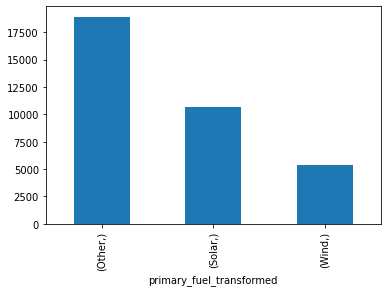

In [3]:
csv_power_plants = pd.read_csv(utils.DIR_DATA_INTERIM/"power_plants_with_generation_transformed.csv", index_col=[0])
df_transformed = pd.read_csv(utils.DIR_DATA_EXTERNAL/"v7_transformed_data_combined_with_nasa.csv", index_col=['index'])
csv_power_plants.index.rename('index', inplace=True)
df_power_plants_raw = pd.read_csv(utils.DIR_DATA_RAW/"global_power_plant_database.csv", usecols=['name','primary_fuel', 'estimated_generation_gwh_2013'], engine='python')
csv_power_plants = csv_power_plants.join(df_power_plants_raw)

columns_to_combine = [
                        'name',
                        'capacity_mw',
                        'primary_fuel_transformed',
                        'generation_gwh_2013',
                        'generation_gwh_2014',
                        'generation_gwh_2015',
                        'generation_gwh_2016',
                        'generation_gwh_2017',
                        'generation_gwh_2018'
                    ]
df_transformed_combined = df_transformed.merge(csv_power_plants[columns_to_combine],left_on="index", right_on="index")
print(df_transformed_combined[['primary_fuel_transformed']].value_counts())
df_transformed_combined[['primary_fuel_transformed']].value_counts().plot.bar()

In [4]:
df_solar = df_transformed_combined[df_transformed_combined['primary_fuel_transformed']== "Solar"]
df_solar = df_solar[~df_solar['name'].str.contains('CSP')]
df_solar

latitude  longitude  ANN_ALLSKY_SFC_SW_DNI_2013  \
index                                                    
1        31.670     65.795                        7.06   
2        31.623     65.792                        7.06   
17       27.908     -0.317                        6.21   
18       35.880      5.475                        5.67   
20       34.532      0.804                        6.08   
...         ...        ...                         ...   
34833    11.700    108.900                        3.99   
34847    11.446    108.866                        3.99   
34894    16.440    107.505                        2.67   
34895    11.700    109.030                        4.00   
34921   -15.550     28.350                        6.04   

       ANN_ALLSKY_SFC_SW_DNI_2014  ANN_ALLSKY_SFC_SW_DNI_2015  \
index                                                           
1                            7.20                        6.83   
2                            7.20                        6.83   
17                           6.06                        5.75   
18                           5.68                        5.70   
20                           5.86                        5.93   
...                           ...                         ...   
34833                        4.55                        4.80   
34847                        4.55                        4.80   
34894                        3.33                        3.73   
34895                        4.53                        4.96   
34921                        5.75                        6.08   

       ANN_ALLSKY_SFC_SW_DNI_2016  ANN_ALLSKY_SFC_SW_DNI_2017  \
index                                                           
1                            7.47                        7.23   
2                            7.47                        7.23   
17                           5.70                        5.90   
18                           5.61                        5.89   
20                           5.87                        6.06   
...                           ...                         ...   
34833                        3.99                        3.59   
34847                        3.99                        3.59   
34894                        2.76                        2.82   
34895                        4.18                        3.78   
34921                        5.79                        5.19   

       ANN_ALLSKY_SFC_SW_DNI_2018  ANN_ALLSKY_SFC_SW_DNI_2019  \
index                                                           
1                            7.03                        6.90   
2                            7.03                        6.90   
17                           5.78                        6.28   
18                           5.49                        5.78   
20                           5.72                        6.25   
...                           ...                         ...   
34833                        3.99                        4.58   
34847                        3.99                        4.58   
34894                        3.12                        3.39   
34895                        4.05                        4.65   
34921                        5.74                        6.13   

       ANN_ALLSKY_SFC_SW_DWN_2013  ...  std_WS50M_RANGE_AVG_2019  \
index                              ...                             
1                            6.05  ...                     0.565   
2                            6.05  ...                     0.565   
17                           6.15  ...                     0.602   
18                           5.21  ...                     0.567   
20                           5.34  ...                     0.886   
...                           ...  ...                       ...   
34833                        5.23  ...                     0.250   
34847                        5.23  ...                     0.250   
34894                        4.00 

In [5]:
columns_delete = df_solar.columns.str.contains('mean')

df_solar = df_solar.loc[:,~columns_delete]

In [10]:
LIST_YEARS = ['2013', '2014', '2015', '2016', '2017', '2018']
dict_df_years = {}

for year in LIST_YEARS:
    df_aux = df_solar[df_solar[f'generation_gwh_{year}'].notna()]
    columns_keep_aux = df_aux.columns.str.contains(year) | df_aux.columns.str.contains('capacity_mw')
    df_aux = df_aux.loc[:,columns_keep_aux]
    df_aux = df_aux.loc[:,~df_aux.columns.str.contains('WS')]
    dict_columns = {a:a.replace(f'_{year}', '') for a in df_aux.columns}
    df_aux.rename(columns=dict_columns, inplace=True)
    dict_df_years[year] = df_aux

df_all_concat = pd.concat(dict_df_years.values())
df_all_concat.reset_index(drop=True, inplace = True)

In [11]:
df_all_concat

ANN_ALLSKY_SFC_SW_DNI  ANN_ALLSKY_SFC_SW_DWN  ANN_ALLSKY_SFC_SW_UP  \
0                      7.45                   5.79                  1.02   
1                      4.28                   3.98                  0.52   
2                      5.35                   5.04                  0.46   
3                      4.28                   3.98                  0.52   
4                      4.28                   3.98                  0.52   
...                     ...                    ...                   ...   
9655                   4.53                   4.40                  0.58   
9656                   4.81                   4.58                  0.62   
9657                   4.81                   4.58                  0.62   
9658                   4.81                   4.58                  0.62   
9659                   4.11                   3.83                  0.94   

      ANN_ALLSKY_SFC_SW_UP_MAX  ANN_CLOUD_AMT_DAY  ANN_CLRSKY_SFC_SW_DNI  \
0                         1.82              33.80                   9.54   
1                         1.23              58.62                   7.24   
2                         0.96              54.92                   8.75   
3                         1.23              58.62                   7.24   
4                         1.23              58.62                   7.24   
...                        ...                ...                    ...   
9655                      1.22              58.46                   7.61   
9656                      1.31              53.99                   7.60   
9657                      1.31              53.99                   7.60   
9658                      1.31              53.99                   7.60   
9659                      4.16              63.97                   7.88   

      ANN_CLRSKY_SFC_SW_DWN  ANN_CLRSKY_SFC_SW_UP  ANN_T2M  \
0                      6.54                  1.16    18.42   
1                      5.40                  0.72    11.73   
2                      6.18                  0.55    17.25   
3                      5.40                  0.72    11.19   
4                      5.40                  0.72    11.19   
...                     ...                   ...      ...   
9655                   5.84                  0.78    16.36   
9656                   5.84                  0.79    16.85   
9657                   5.84                  0.79    16.85   
9658                   5.84                  0.79    16.85   
9659                   5.28                  1.28     6.62   

      max_ALLSKY_SFC_SW_DNI  ...  std_ALLSKY_SFC_SW_DWN  std_ALLSKY_SFC_SW_UP  \
0                     10.92  ...                  2.095                 0.417   
1                      5.99  ...                  1.621                 0.192   
2                      6.58  ...                  1.267                 0.180   
3                      5.99  ...                  1.621                 0.192   
4                      5.99  ...                  1.621                 0.192   
...                     ...  ...                    ...                   ...   
9655                   5.76  ...                  1.582                 0.224   
9656                   5.89  ...                  1.554                 0.227   
9657                   5.89  ...                  1.554                 0.227   
9658                   5.89  ...                  1.554                 0.227   
9659                   6.59  ...                  1.783                 0.543   

      std_ALLSKY_SFC_SW_UP_MAX  std_CLOUD_AMT_DAY  std_CLRSKY_SFC_SW_DNI  \
0                        0.451             11.007                  1.666   
1                        0.273              7.587                  0.923   
2                        0.216             13.787                  1.007   
3                        0.273              7.587                  0.923   
4                        0.273              7.587                  0.923   
...   

In [12]:
df_all_concat['generation_gwh'].isna().sum()

0

In [13]:
df_all_concat['capacity_factor'] = df_all_concat['generation_gwh'] / ((df_all_concat['capacity_mw'] / 1000) * 8760)
df_all_concat = df_all_concat[(df_all_concat['capacity_factor'] > 0.1) & (df_all_concat['capacity_factor'] < 1)]

In [14]:
df_all_concat['capacity_factor'].describe()

count    7904.000000
mean        0.203643
std         0.055285
min         0.100320
25%         0.165411
50%         0.196630
75%         0.231417
max         0.756849
Name: capacity_factor, dtype: float64

# REMOVING OUTLIERS

In [16]:

# columns_not_consider_outliers = [
#                                     'capacity_mw',
#                                     'latitude',
#                                     'longitude',
#                                     'primary_fuel_transformed',
#                                     'code_prim_fuel_transf',
#                                     'generation_gwh_2013',
#                                     'generation_gwh_2014',
#                                     'generation_gwh_2015',
#                                     'generation_gwh_2016',
#                                     'generation_gwh_2017',
#                                     'generation_gwh_2018',
#                                     'generation_gwh_2019'
#                                 ]
# X = X.loc[:,~columns_delete]                        
df_all_concat_remove_outliers = df_all_concat[['capacity_factor', 'generation_gwh']]
iso = IsolationForest(max_samples='auto',contamination='auto')
yhat = iso.fit_predict(df_all_concat_remove_outliers)
# select all rows that are outliers
mask = yhat == -1
index_outliers = df_all_concat[mask].index

<AxesSubplot:xlabel='capacity_factor', ylabel='capacity_mw'>

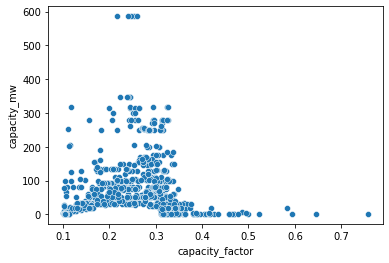

In [17]:
# df_all_concat.loc[mask,['generation_gwh', 'capacity_mw']]
sns.scatterplot(data=df_all_concat.loc[mask,['capacity_factor', 'capacity_mw']], x="capacity_factor", y="capacity_mw")

<AxesSubplot:xlabel='capacity_factor', ylabel='capacity_mw'>

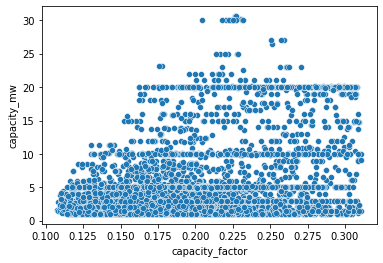

In [18]:
sns.scatterplot(data=df_all_concat.loc[:,['capacity_factor', 'capacity_mw']].drop(index_outliers, axis=0), x="capacity_factor", y="capacity_mw")

<AxesSubplot:xlabel='capacity_factor', ylabel='capacity_mw'>

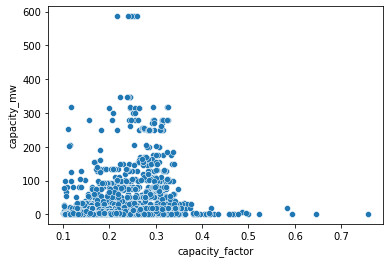

In [20]:
sns.scatterplot(data=df_all_concat.loc[:,['capacity_factor', 'capacity_mw']], x="capacity_factor", y="capacity_mw")


In [21]:
df_all_concat.drop(index_outliers, axis=0, inplace =True)

/tmp/ipykernel_289/1536400504.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_concat.drop(index_outliers, axis=0, inplace =True)


In [22]:
df_all_concat.drop(columns=['capacity_factor'], inplace = True)

/tmp/ipykernel_289/959146686.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_concat.drop(columns=['capacity_factor'], inplace = True)


In [23]:
df_all_concat.describe()

ANN_ALLSKY_SFC_SW_DNI  ANN_ALLSKY_SFC_SW_DWN  ANN_ALLSKY_SFC_SW_UP  \
count            6946.000000            6946.000000           6946.000000   
mean                5.414480               4.637442              0.690789   
std                 1.432649               0.731254              0.239032   
min                 3.030000               3.400000              0.160000   
25%                 4.280000               3.990000              0.530000   
50%                 4.770000               4.480000              0.620000   
75%                 6.950000               5.330000              0.860000   
max                 8.250000               6.570000              1.560000   

       ANN_ALLSKY_SFC_SW_UP_MAX  ANN_CLOUD_AMT_DAY  ANN_CLRSKY_SFC_SW_DNI  \
count               6946.000000        6946.000000            6946.000000   
mean                   1.543956          49.802748               8.117098   
std                    0.549821          13.310471               0.869274   
min                    0.320000          21.160000               6.800000   
25%                    1.260000          36.490000               7.470000   
50%                    1.460000          54.520000               7.690000   
75%                    1.780000          59.570000               9.030000   
max                    5.530000          79.110000              10.220000   

       ANN_CLRSKY_SFC_SW_DWN  ANN_CLRSKY_SFC_SW_UP      ANN_T2M  \
count            6946.000000           6946.000000  6946.000000   
mean                5.782518              0.863067    14.388061   
std                 0.376717              0.230643     4.191473   
min                 5.180000              0.220000     3.150000   
25%                 5.410000              0.740000    10.940000   
50%                 5.790000              0.810000    15.360000   
75%                 6.100000              1.000000    17.310000   
max                 7.560000              1.670000    25.260000   

       max_ALLSKY_SFC_SW_DNI  ...  std_ALLSKY_SFC_SW_DWN  \
count            6946.000000  ...            6946.000000   
mean                7.484814  ...               1.732347   
std                 2.072122  ...               0.247208   
min                 4.240000  ...               0.505000   
25%                 5.880000  ...               1.563000   
50%                 6.470000  ...               1.698000   
75%                 9.570000  ...               1.843000   
max                11.990000  ...               2.506000   

       std_ALLSKY_SFC_SW_UP  std_ALLSKY_SFC_SW_UP_MAX  std_CLOUD_AMT_DAY  \
count           6946.000000               6946.000000        6946.000000   
mean               0.263433                  0.335488          10.772610   
std                0.086087                  0.139660           3.796222   
min                0.027000                  0.019000           5.366000   
25%                0.215000                  0.263000           8.461000   
50%                0.243000                  0.326000           9.529000   
75%                0.321000                  0.389000          11.642000   
max                0.672000                  1.511000          24.500000   

       std_CLRSKY_SFC_SW_DNI  std_CLRSKY_SFC_SW_DWN  std_CLRSKY_SFC_SW_UP  \
count            6946.000000            6946.000000           6946.000000   
mean                1.026878               1.964945              0.287774   
std                 0.280794               0.192576              0.083076   
min                 0.370000               0.634000              0.012000   
25%                 0.758000               1.827000              0.251000   
50%                 1.020000               1.987000              0.280000   
75%                 1.210000               2.117000              0.334000   
max                 1.992000               2.508000              0.778000   

           std_T2M  capacity_mw  generation_gwh  
count  6946.000000  6946.000000     6946.0000

# CORRELATION AND MUTUAL INFORMATION SCORES

## All Best K

/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/env_renewable_power_plants_pred/lib/python3.8/site-packages/sklearn/utils/validation.py:1107: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


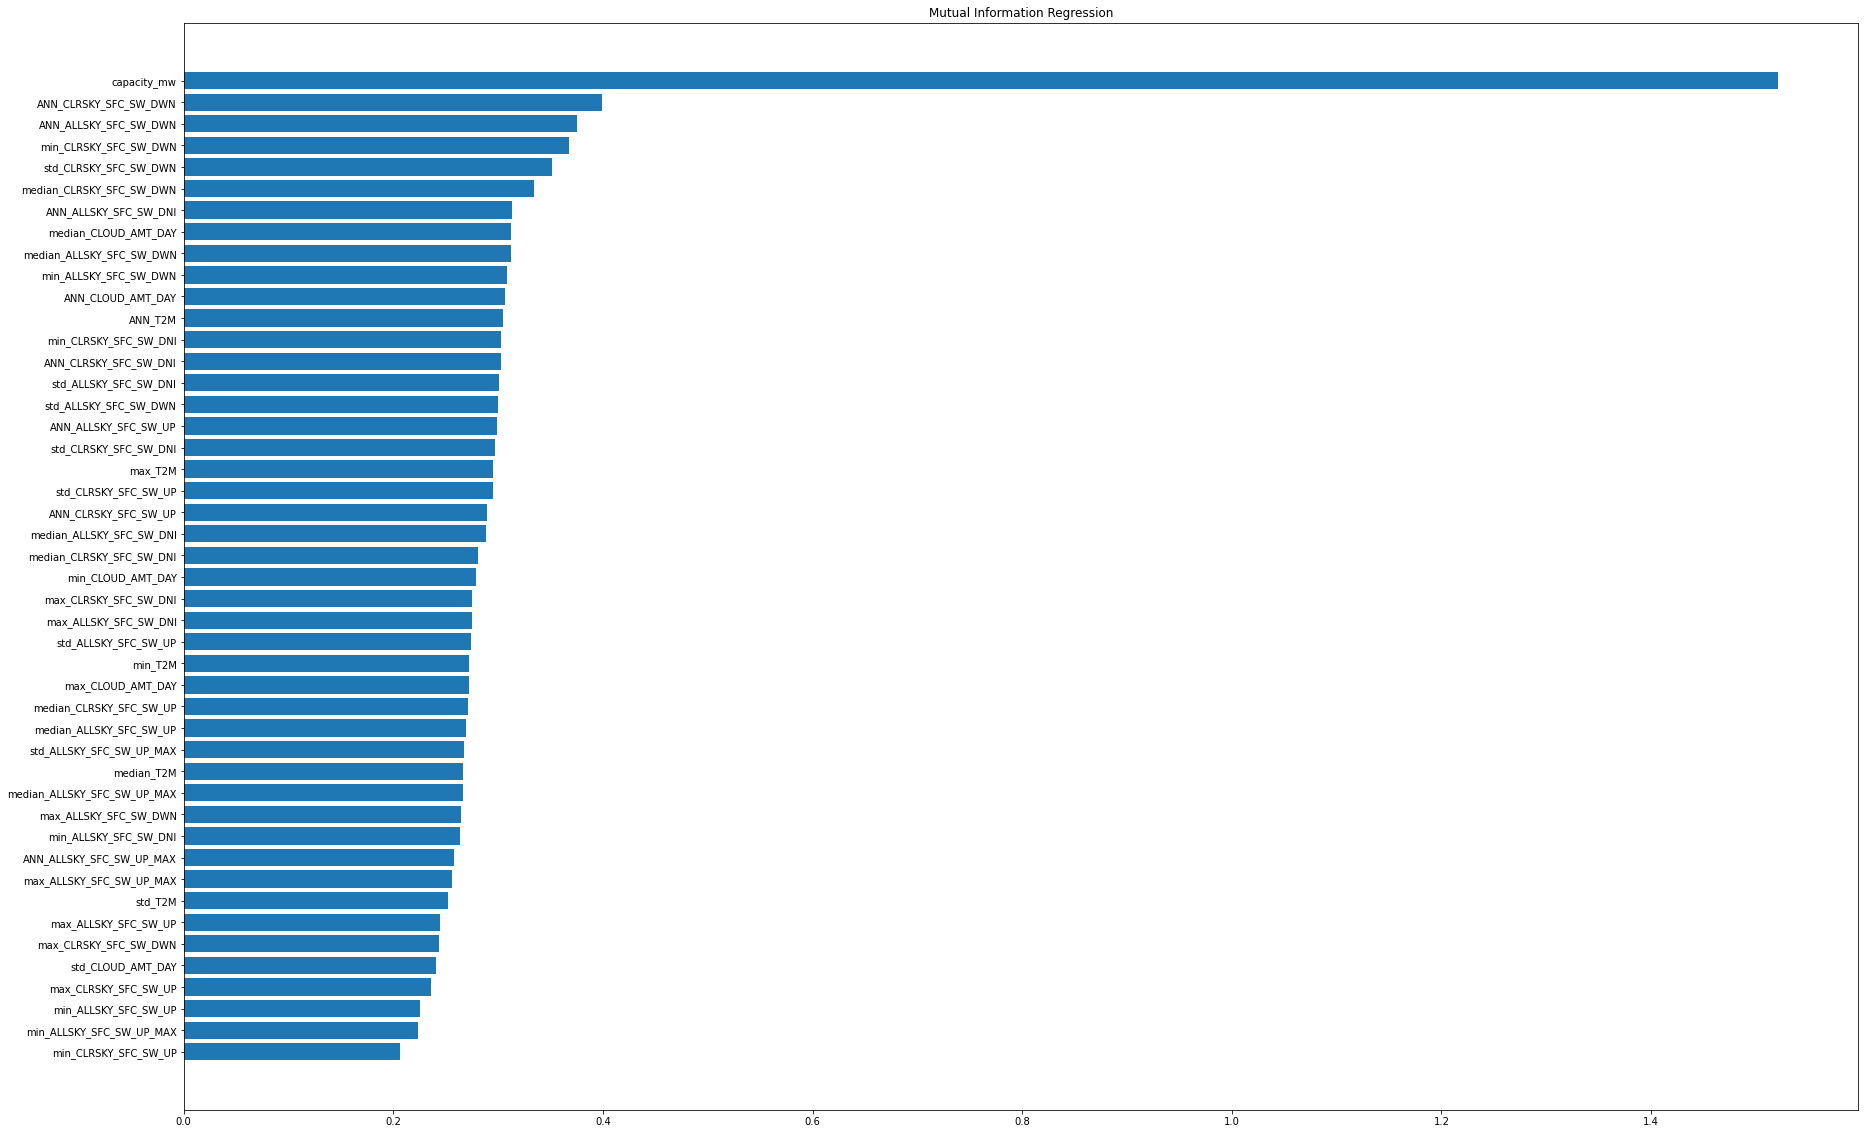

In [24]:
mi_scores = utils.make_mi_scores(df_all_concat.drop(columns=['generation_gwh']), df_all_concat[['generation_gwh']], "regression")

plt.figure(figsize=(30,20))
utils.plot_scores(mi_scores, "Mutual Information Regression")

In [25]:
X = df_all_concat.drop(columns=['generation_gwh'])
y = df_all_concat['generation_gwh']

selector = SelectKBest(mutual_info_regression, k= 10)
new_X = selector.fit_transform(X, y)
cols = selector.get_support(indices=True)
features_df_new = X.iloc[:,cols]

df_all_concat_best_k_mi = pd.concat([features_df_new,y], axis=1)

## All Linear Correlations (Pearson) > 0.20 Dataset

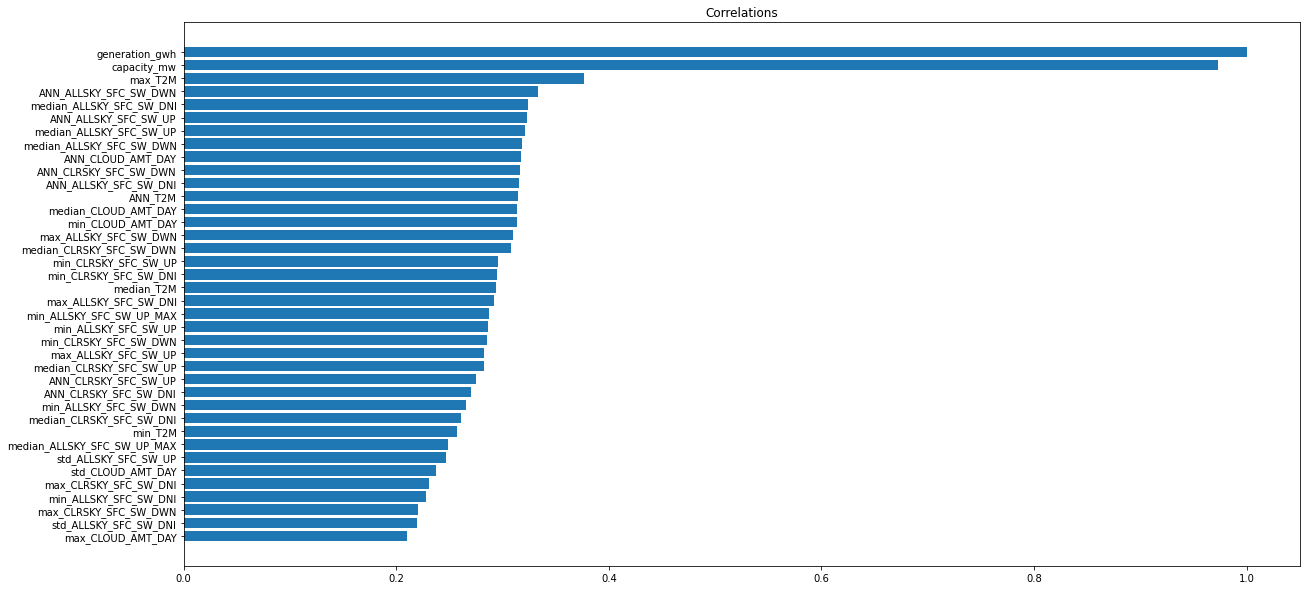

In [26]:
from matplotlib.pyplot import xlabel


corr_matrix = df_all_concat.corr().abs()



target_correlations = corr_matrix.unstack()['generation_gwh'].sort_values(ascending=False)
plt.figure(figsize=(20,10))
# plt.figure(dpi=100, figsize=(4, 10))
utils.plot_scores(target_correlations[target_correlations > .20], "Correlations")

In [27]:
df_all_concat_lin_corr = df_all_concat[target_correlations[target_correlations > .20].index]
df_all_concat_lin_corr

generation_gwh  capacity_mw  max_T2M  ANN_ALLSKY_SFC_SW_DWN  \
1            2.41461          1.9    24.59                   3.98   
2            1.52800          1.3    23.25                   5.04   
3            5.03600          3.8    24.64                   3.98   
4            2.74100          1.9    24.64                   3.98   
5            1.89400          1.0    23.25                   5.74   
...              ...          ...      ...                    ...   
9655         3.55000          2.0    27.09                   4.40   
9656         9.67800          5.0    27.21                   4.58   
9657         9.02400          4.9    27.21                   4.58   
9658         9.39600          5.0    27.21                   4.58   
9659         1.16100          1.0    22.24                   3.83   

      median_ALLSKY_SFC_SW_DNI  ANN_ALLSKY_SFC_SW_UP  median_ALLSKY_SFC_SW_UP  \
1                        4.290                  0.52                    0.565   
2                        5.535                  0.46                    0.420   
3                        4.290                  0.52                    0.565   
4                        4.290                  0.52                    0.565   
5                        7.820                  0.87                    0.905   
...                        ...                   ...                      ...   
9655                     4.890                  0.58                    0.550   
9656                     5.035                  0.62                    0.590   
9657                     5.035                  0.62                    0.590   
9658                     5.035                  0.62                    0.590   
9659                     4.235                  0.94                    0.895   

      median_ALLSKY_SFC_SW_DWN  ANN_CLOUD_AMT_DAY  ANN_CLRSKY_SFC_SW_DWN  ...  \
1                        4.230              58.62                   5.40  ...   
2                        5.230              54.92                   6.18  ...   
3                        4.230              58.62                   5.40  ...   
4                        4.230              58.62                   5.40  ...   
5                        5.985              27.02                   6.28  ...   
...                        ...                ...                    ...  ...   
9655                     4.360              58.46                   5.84  ...   
9656                     4.585              53.99                   5.84  ...   
9657                     4.585              53.99                   5.84  ...   
9658                     4.585              53.99                   5.84  ...   
9659                     4.040              63.97                   5.28  ...   

      median_CLRSKY_SFC_SW_DNI  min_T2M  median_ALLSKY_SFC_SW_UP_MAX  \
1                        7.200     0.60                        0.970   
2                        8.905    10.33                        0.510   
3                        7.200    -0.49                        0.970   
4                        7.200    -0.49                        0.970   
5                        9.280    10.33                        1.265   
...                        ...      ...                          ...   
9655                     7.615     2.27                        0.905   
9656                     7.635     2.63                        0.995   
9657                     7.635     2.63                        0.995   
9658                     7.635     2.63                        0.995   
9659                     7.835   -10.62                        1.355   

      std_ALLSKY_SFC_SW_UP  std_CLOUD_AMT_DAY  max_CLRSKY_SFC_SW_DNI  \
1                    0.192              7.587                   8.49   
2                    0.180             13.787                  10.45   
3                    0.192              7.587                   8.49   
4                    0.192              7.587                   8.49   
5     

In [28]:
df_all_concat_lin_corr.columns

Index(['generation_gwh', 'capacity_mw', 'max_T2M', 'ANN_ALLSKY_SFC_SW_DWN',
       'median_ALLSKY_SFC_SW_DNI', 'ANN_ALLSKY_SFC_SW_UP',
       'median_ALLSKY_SFC_SW_UP', 'median_ALLSKY_SFC_SW_DWN',
       'ANN_CLOUD_AMT_DAY', 'ANN_CLRSKY_SFC_SW_DWN', 'ANN_ALLSKY_SFC_SW_DNI',
       'ANN_T2M', 'median_CLOUD_AMT_DAY', 'min_CLOUD_AMT_DAY',
       'max_ALLSKY_SFC_SW_DWN', 'median_CLRSKY_SFC_SW_DWN',
       'min_CLRSKY_SFC_SW_UP', 'min_CLRSKY_SFC_SW_DNI', 'median_T2M',
       'max_ALLSKY_SFC_SW_DNI', 'min_ALLSKY_SFC_SW_UP_MAX',
       'min_ALLSKY_SFC_SW_UP', 'min_CLRSKY_SFC_SW_DWN', 'max_ALLSKY_SFC_SW_UP',
       'median_CLRSKY_SFC_SW_UP', 'ANN_CLRSKY_SFC_SW_UP',
       'ANN_CLRSKY_SFC_SW_DNI', 'min_ALLSKY_SFC_SW_DWN',
       'median_CLRSKY_SFC_SW_DNI', 'min_T2M', 'median_ALLSKY_SFC_SW_UP_MAX',
       'std_ALLSKY_SFC_SW_UP', 'std_CLOUD_AMT_DAY', 'max_CLRSKY_SFC_SW_DNI',
       'min_ALLSKY_SFC_SW_DNI', 'max_CLRSKY_SFC_SW_DWN',
       'std_ALLSKY_SFC_SW_DNI', 'max_CLOUD_AMT_DAY'],
      dtype=

## Annual Dataset

In [29]:
corr_matrix

ANN_ALLSKY_SFC_SW_DNI  ANN_ALLSKY_SFC_SW_DWN  \
ANN_ALLSKY_SFC_SW_DNI                     1.000000               0.968927   
ANN_ALLSKY_SFC_SW_DWN                     0.968927               1.000000   
ANN_ALLSKY_SFC_SW_UP                      0.829077               0.784145   
ANN_ALLSKY_SFC_SW_UP_MAX                  0.179585               0.091820   
ANN_CLOUD_AMT_DAY                         0.981896               0.954005   
ANN_CLRSKY_SFC_SW_DNI                     0.906468               0.865467   
ANN_CLRSKY_SFC_SW_DWN                     0.860958               0.947139   
ANN_CLRSKY_SFC_SW_UP                      0.659746               0.603781   
ANN_T2M                                   0.658499               0.777165   
max_ALLSKY_SFC_SW_DNI                     0.919345               0.845422   
max_ALLSKY_SFC_SW_DWN                     0.931999               0.887082   
max_ALLSKY_SFC_SW_UP                      0.725086               0.656073   
max_ALLSKY_SFC_SW_UP_MAX                  0.179585               0.091820   
max_CLOUD_AMT_DAY                         0.788550               0.791038   
max_CLRSKY_SFC_SW_DNI                     0.825468               0.740466   
max_CLRSKY_SFC_SW_DWN                     0.807135               0.712241   
max_CLRSKY_SFC_SW_UP                      0.493485               0.416521   
max_T2M                                   0.581540               0.652927   
median_ALLSKY_SFC_SW_DNI                  0.985986               0.962543   
median_ALLSKY_SFC_SW_DWN                  0.946925               0.974182   
median_ALLSKY_SFC_SW_UP                   0.841501               0.792305   
median_ALLSKY_SFC_SW_UP_MAX               0.627897               0.556551   
median_CLOUD_AMT_DAY                      0.970412               0.942146   
median_CLRSKY_SFC_SW_DNI                  0.905764               0.867597   
median_CLRSKY_SFC_SW_DWN                  0.830289               0.928433   
median_CLRSKY_SFC_SW_UP                   0.687474               0.627853   
median_T2M                                0.575981               0.701012   
min_ALLSKY_SFC_SW_DNI                     0.822000               0.849936   
min_ALLSKY_SFC_SW_DWN                     0.787325               0.885018   
min_ALLSKY_SFC_SW_UP                      0.794084               0.792460   
min_ALLSKY_SFC_SW_UP_MAX                  0.670566               0.669017   
min_CLOUD_AMT_DAY                         0.943328               0.901251   
min_CLRSKY_SFC_SW_DNI                     0.849534               0.872738   
min_CLRSKY_SFC_SW_DWN                     0.679764               0.826827   
min_CLRSKY_SFC_SW_UP                      0.710803               0.709346   
min_T2M                                   0.699126               0.797093   
std_ALLSKY_SFC_SW_DNI                     0.618856               0.504060   
std_ALLSKY_SFC_SW_DWN                     0.499434               0.342346   
std_ALLSKY_SFC_SW_UP                      0.596371               0.502047   
std_ALLSKY_SFC_SW_UP_MAX                  0.055253               0.048219   
std_CLOUD_AMT_DAY                         0.537694               0.476881   
std_CLRSKY_SFC_SW_DNI                     0.297024               0.132803   
std_CLRSKY_SFC_SW_DWN                     0.129739               0.340272   
std_CLRSKY_SFC_SW_UP                      0.352989               0.247325   
std_T2M                                   0.594044               0.679708   
capacity_mw                               0.227863               0.252011   
generation_gwh                            0.315181               0.333271   

                             ANN_ALLSKY_SFC_SW_UP  ANN_ALLSKY_SFC_SW_UP_MAX  \
ANN_ALLSKY_SFC_SW_DNI                    0.829077                  0.179585   
ANN_ALLSKY_SFC_SW_DWN                    0.784145                  0.091820   
ANN_ALLSKY_SFC_SW_UP                     1.000000                  0.573578   
ANN_ALLSKY_SFC_S

In [30]:
columns_keep = df_all_concat.columns.str.contains('generation_gwh') | df_all_concat.columns.str.contains('ANN') | df_all_concat.columns.str.contains('capacity_mw')
df_all_concat_annual = df_all_concat.loc[:,columns_keep]

corr_matrix = df_all_concat_annual.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Find index of feature columns with correlation greater than 0.95
# to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
# df_all_concat_annual.drop(columns=to_drop, inplace=True)

/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/env_renewable_power_plants_pred/lib/python3.8/site-packages/sklearn/utils/validation.py:1107: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


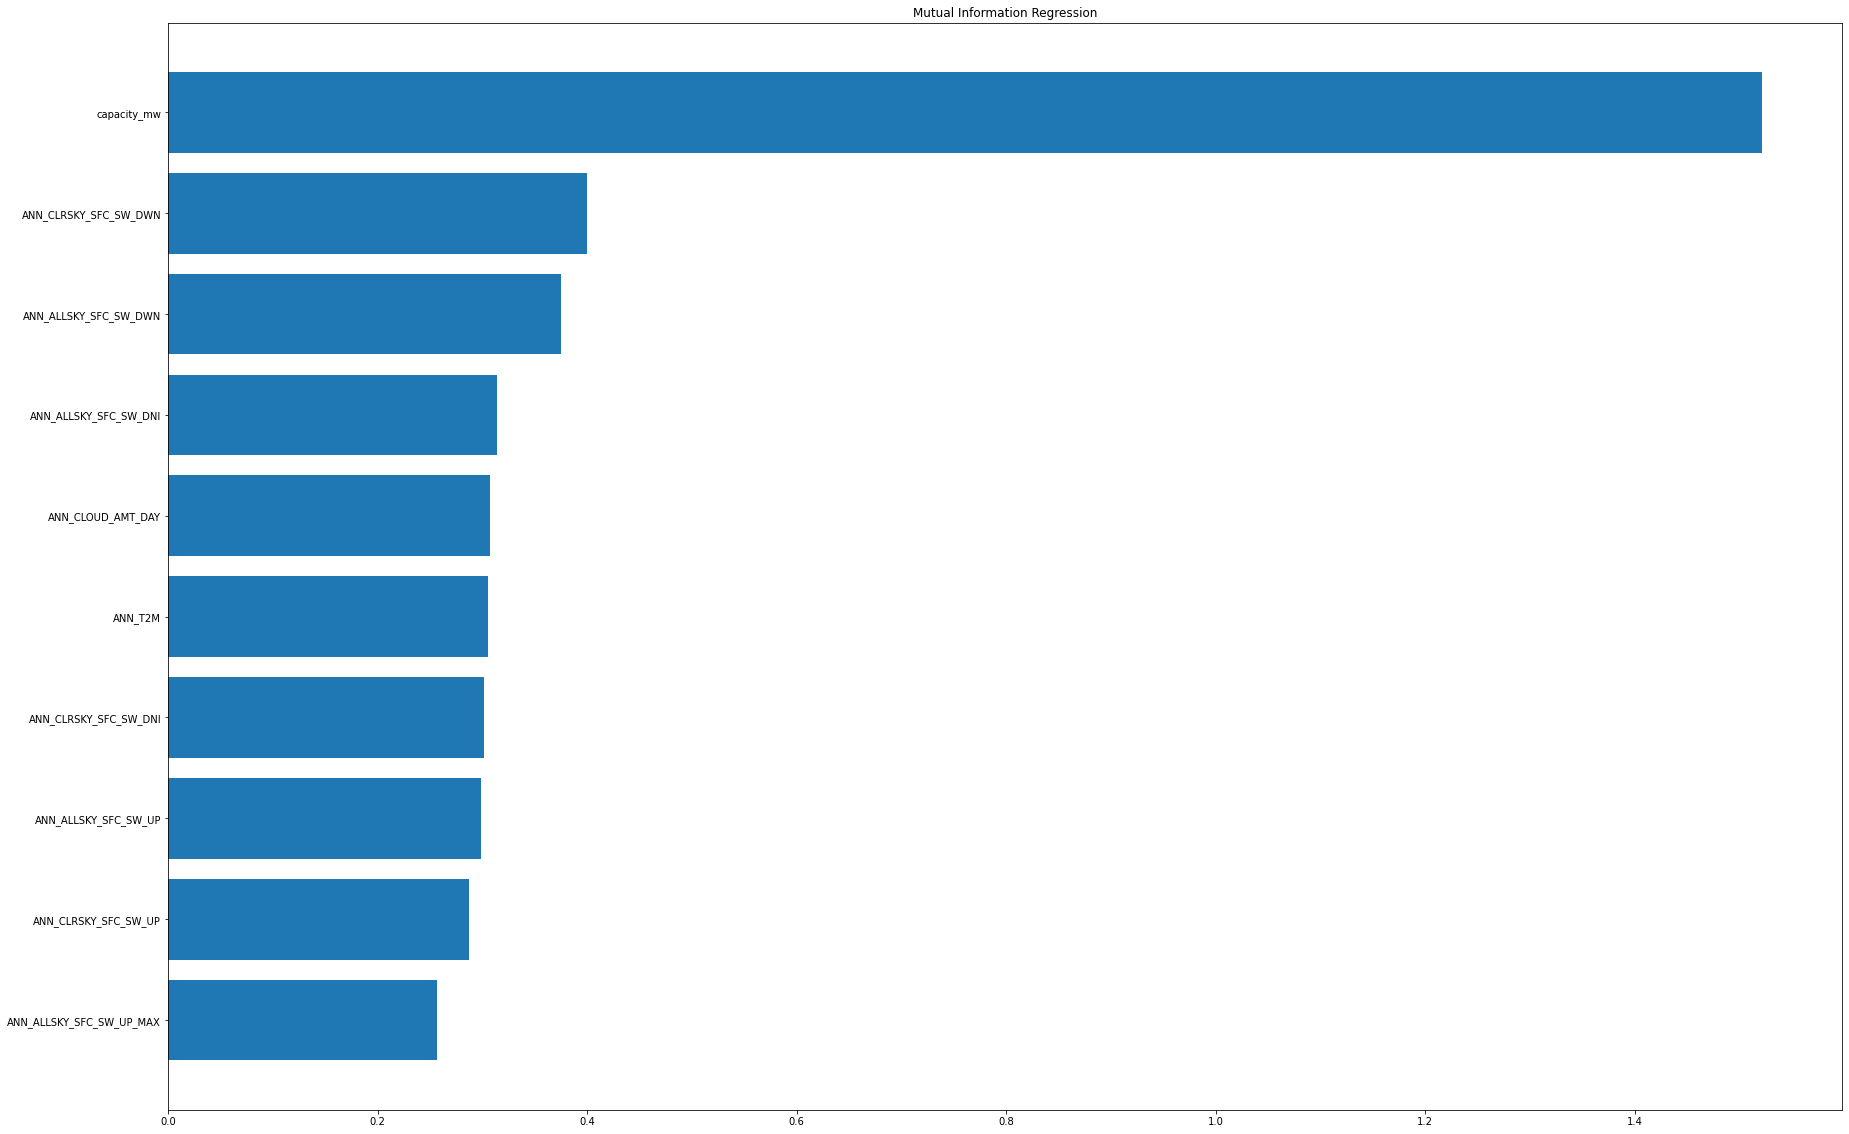

In [31]:
mi_scores = utils.make_mi_scores(df_all_concat_annual.drop(columns=['generation_gwh']), df_all_concat_annual[['generation_gwh']], "regression")

plt.figure(figsize=(30,20))
utils.plot_scores(mi_scores, "Mutual Information Regression")

## Annual Best K (Mutual Information) Dataset 

In [32]:
X = df_all_concat_annual.drop(columns=['generation_gwh'])
y = df_all_concat_annual['generation_gwh']

selector = SelectKBest(mutual_info_regression, k= 10)
new_X = selector.fit_transform(X, y)
cols = selector.get_support(indices=True)
features_df_new = X.iloc[:,cols]

df_all_concat_annual_best_k_mi = pd.concat([features_df_new,y], axis=1)

In [33]:
df_all_concat_annual_best_k_mi

ANN_ALLSKY_SFC_SW_DNI  ANN_ALLSKY_SFC_SW_DWN  ANN_ALLSKY_SFC_SW_UP  \
1                      4.28                   3.98                  0.52   
2                      5.35                   5.04                  0.46   
3                      4.28                   3.98                  0.52   
4                      4.28                   3.98                  0.52   
5                      7.79                   5.74                  0.87   
...                     ...                    ...                   ...   
9655                   4.53                   4.40                  0.58   
9656                   4.81                   4.58                  0.62   
9657                   4.81                   4.58                  0.62   
9658                   4.81                   4.58                  0.62   
9659                   4.11                   3.83                  0.94   

      ANN_ALLSKY_SFC_SW_UP_MAX  ANN_CLOUD_AMT_DAY  ANN_CLRSKY_SFC_SW_DNI  \
1                         1.23              58.62                   7.24   
2                         0.96              54.92                   8.75   
3                         1.23              58.62                   7.24   
4                         1.23              58.62                   7.24   
5                         2.07              27.02                   9.30   
...                        ...                ...                    ...   
9655                      1.22              58.46                   7.61   
9656                      1.31              53.99                   7.60   
9657                      1.31              53.99                   7.60   
9658                      1.31              53.99                   7.60   
9659                      4.16              63.97                   7.88   

      ANN_CLRSKY_SFC_SW_DWN  ANN_CLRSKY_SFC_SW_UP  ANN_T2M  capacity_mw  \
1                      5.40                  0.72    11.73          1.9   
2                      6.18                  0.55    17.25          1.3   
3                      5.40                  0.72    11.19          3.8   
4                      5.40                  0.72    11.19          1.9   
5                      6.28                  0.97    17.25          1.0   
...                     ...                   ...      ...          ...   
9655                   5.84                  0.78    16.36          2.0   
9656                   5.84                  0.79    16.85          5.0   
9657                   5.84                  0.79    16.85          4.9   
9658                   5.84                  0.79    16.85          5.0   
9659                   5.28                  1.28     6.62          1.0   

      generation_gwh  
1            2.41461  
2            1.52800  
3            5.03600  
4            2.74100  
5            1.89400  
...              ...  
9655         3.55000  
9656         9.67800  
9657         9.02400  
9658         9.39600  
9659         1.16100  

[6946 rows x 11 columns]

## Annual Linear Correlations (Pearson) > 0.20 Dataset

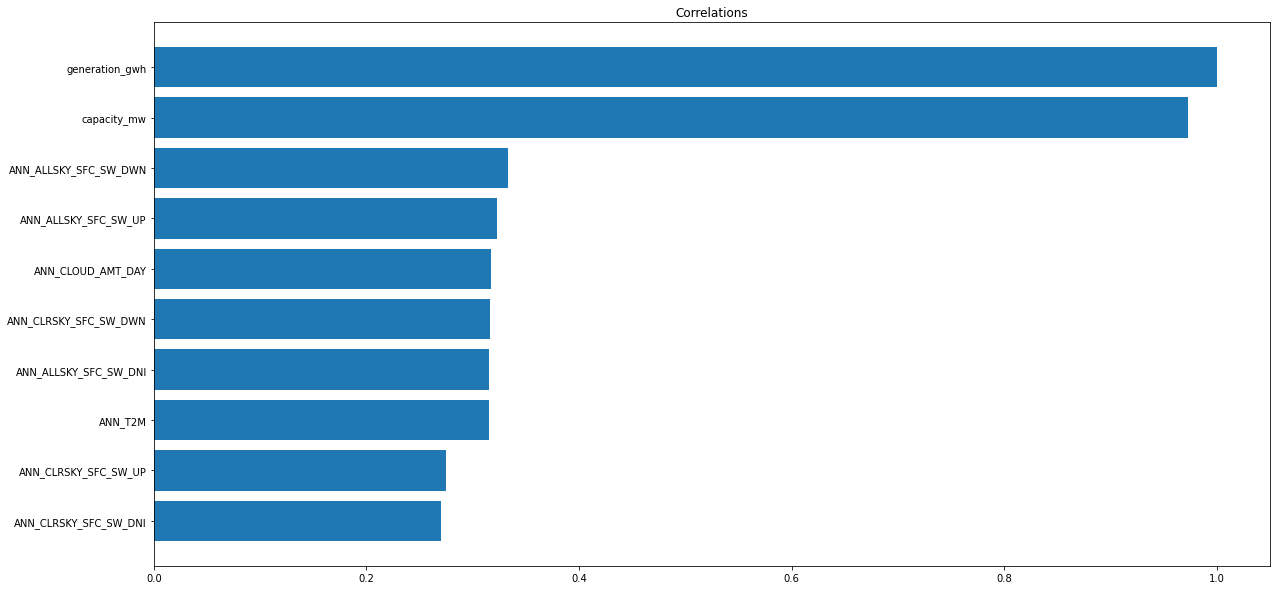

In [34]:
from matplotlib.pyplot import xlabel


corr_matrix = df_all_concat_annual.corr().abs()



target_correlations = corr_matrix.unstack()['generation_gwh'].sort_values(ascending=False)
plt.figure(figsize=(20,10))
# plt.figure(dpi=100, figsize=(4, 10))
utils.plot_scores(target_correlations[target_correlations > .20], "Correlations")

In [35]:
df_all_concat_annual_lin_corr = df_all_concat_annual[target_correlations[target_correlations > .20].index]
df_all_concat_annual_lin_corr

generation_gwh  capacity_mw  ANN_ALLSKY_SFC_SW_DWN  \
1            2.41461          1.9                   3.98   
2            1.52800          1.3                   5.04   
3            5.03600          3.8                   3.98   
4            2.74100          1.9                   3.98   
5            1.89400          1.0                   5.74   
...              ...          ...                    ...   
9655         3.55000          2.0                   4.40   
9656         9.67800          5.0                   4.58   
9657         9.02400          4.9                   4.58   
9658         9.39600          5.0                   4.58   
9659         1.16100          1.0                   3.83   

      ANN_ALLSKY_SFC_SW_UP  ANN_CLOUD_AMT_DAY  ANN_CLRSKY_SFC_SW_DWN  \
1                     0.52              58.62                   5.40   
2                     0.46              54.92                   6.18   
3                     0.52              58.62                   5.40   
4                     0.52              58.62                   5.40   
5                     0.87              27.02                   6.28   
...                    ...                ...                    ...   
9655                  0.58              58.46                   5.84   
9656                  0.62              53.99                   5.84   
9657                  0.62              53.99                   5.84   
9658                  0.62              53.99                   5.84   
9659                  0.94              63.97                   5.28   

      ANN_ALLSKY_SFC_SW_DNI  ANN_T2M  ANN_CLRSKY_SFC_SW_UP  \
1                      4.28    11.73                  0.72   
2                      5.35    17.25                  0.55   
3                      4.28    11.19                  0.72   
4                      4.28    11.19                  0.72   
5                      7.79    17.25                  0.97   
...                     ...      ...                   ...   
9655                   4.53    16.36                  0.78   
9656                   4.81    16.85                  0.79   
9657                   4.81    16.85                  0.79   
9658                   4.81    16.85                  0.79   
9659                   4.11     6.62                  1.28   

      ANN_CLRSKY_SFC_SW_DNI  
1                      7.24  
2                      8.75  
3                      7.24  
4                      7.24  
5                      9.30  
...                     ...  
9655                   7.61  
9656                   7.60  
9657                   7.60  
9658                   7.60  
9659                   7.88  

[6946 rows x 10 columns]

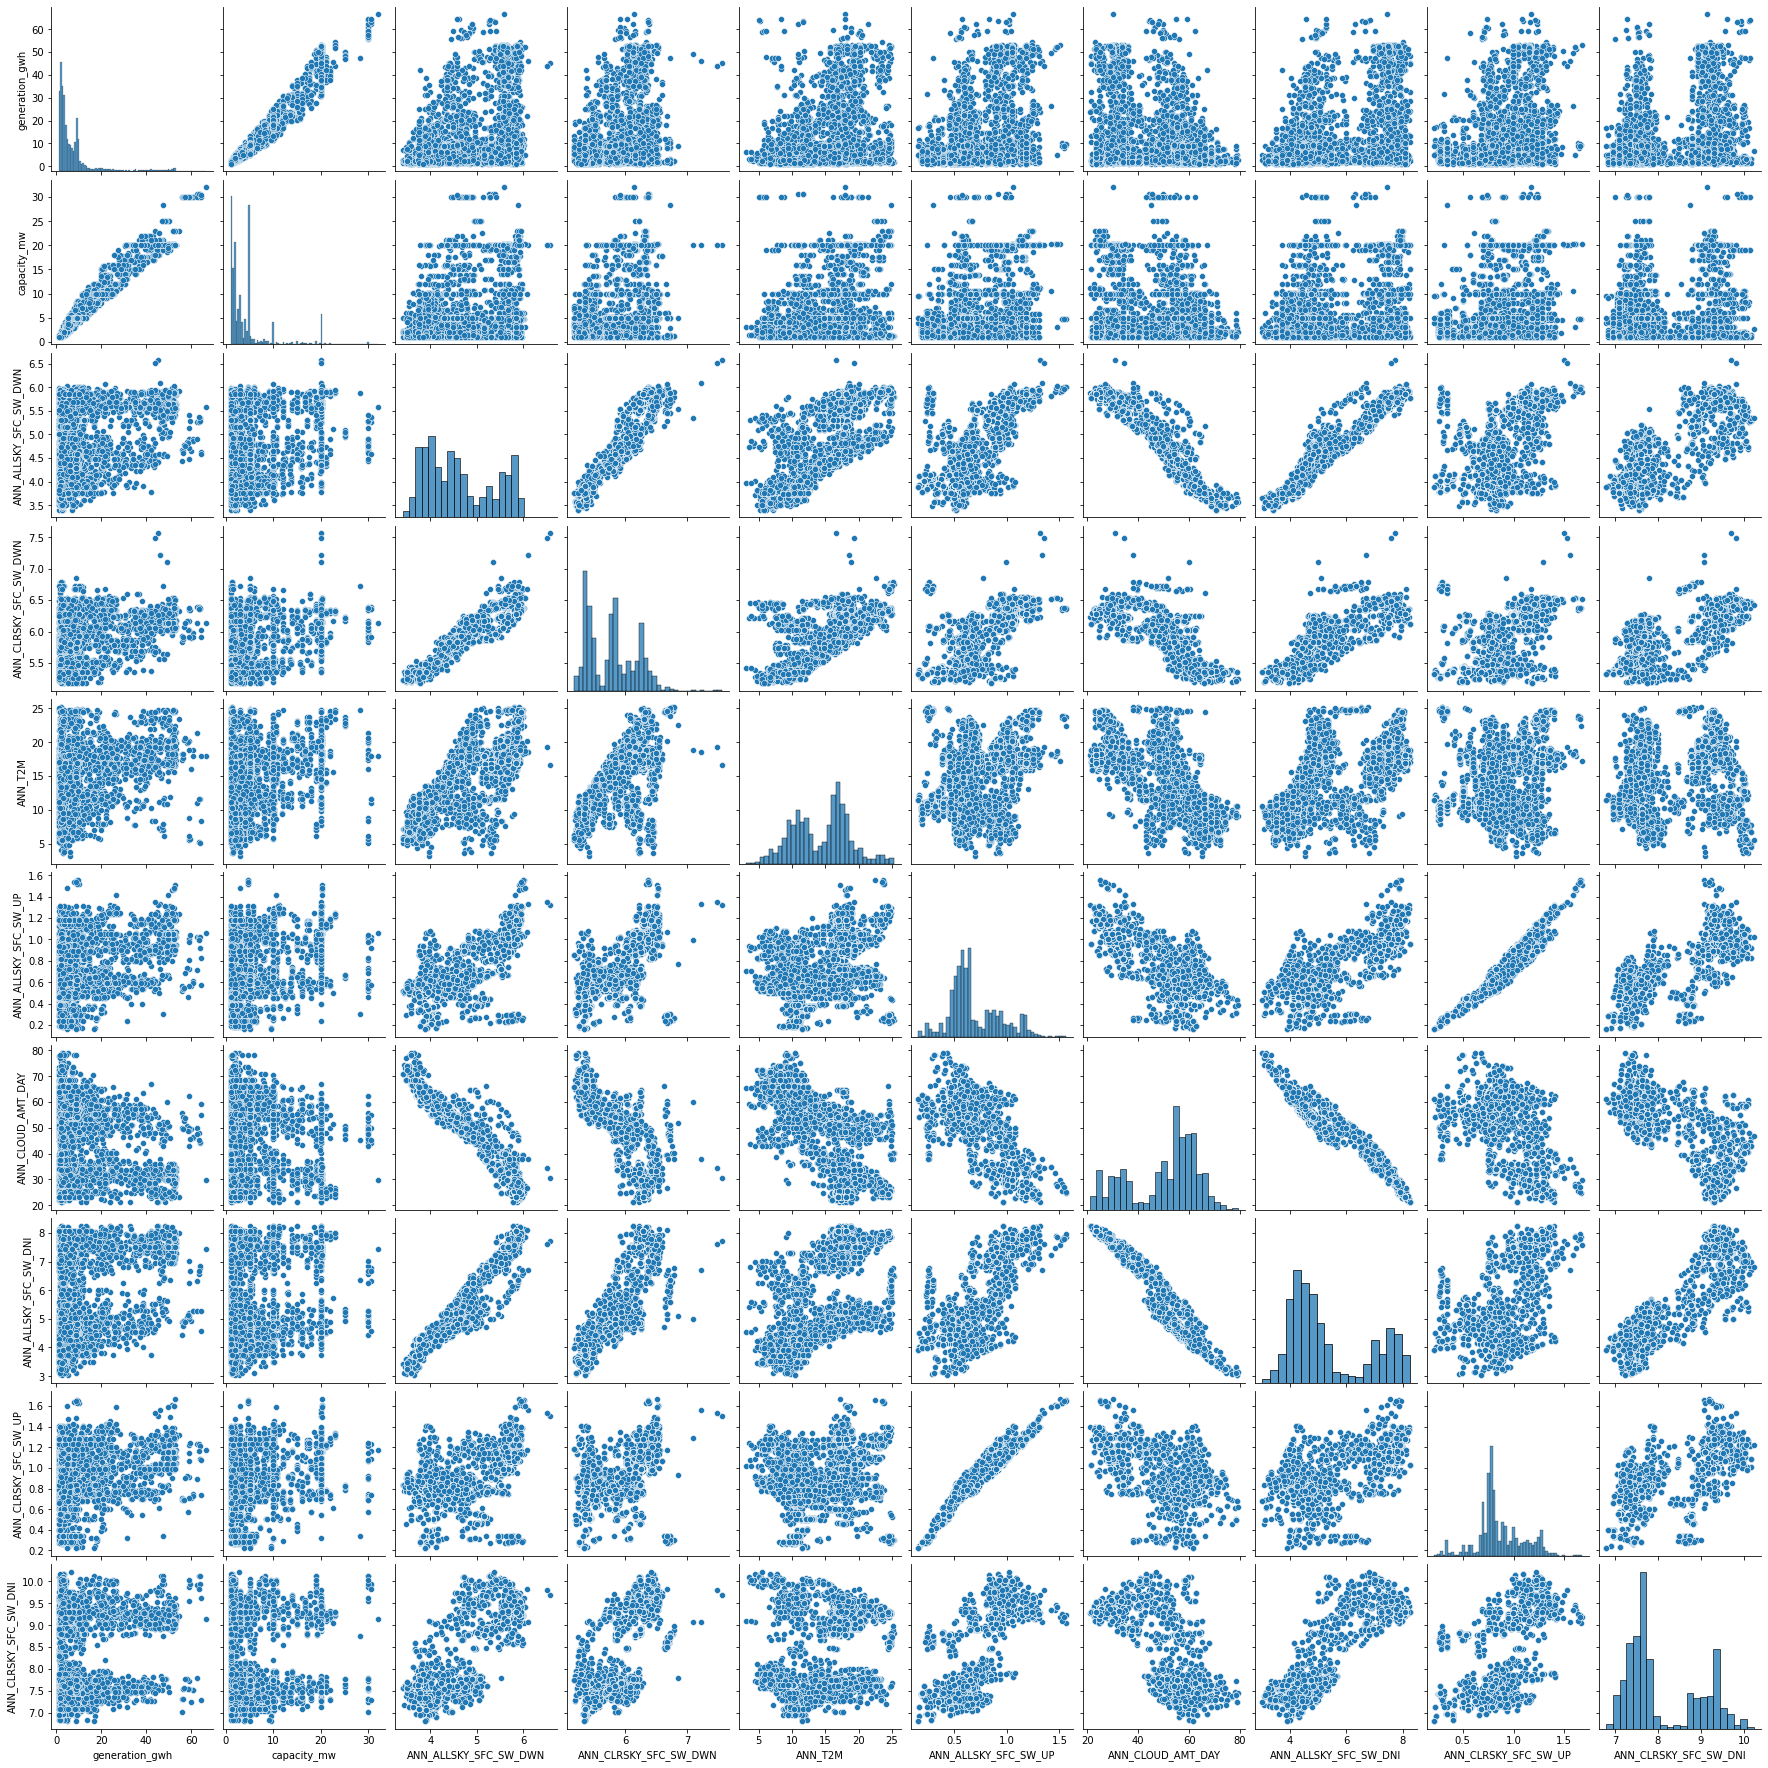

In [35]:
sns.pairplot(df_all_concat_annual_lin_corr)

## Capacity and Shortwave Down features

In [36]:
columns_keep = df_all_concat.columns.str.contains('generation_gwh') | df_all_concat.columns.str.contains('SW_DWN') | df_all_concat.columns.str.contains('capacity_mw') | df_all_concat.columns.str.contains('capacity_factor')
df_all_concat_capacity_shortwave_down = df_all_concat.loc[:,columns_keep]
df_all_concat_capacity_shortwave_down
# sns.pairplot(df_all_concat_capacity_shortwave_down)

ANN_ALLSKY_SFC_SW_DWN  ANN_CLRSKY_SFC_SW_DWN  max_ALLSKY_SFC_SW_DWN  \
1                      3.98                   5.40                   5.94   
2                      5.04                   6.18                   7.08   
3                      3.98                   5.40                   5.94   
4                      3.98                   5.40                   5.94   
5                      5.74                   6.28                   8.01   
...                     ...                    ...                    ...   
9655                   4.40                   5.84                   6.68   
9656                   4.58                   5.84                   6.73   
9657                   4.58                   5.84                   6.73   
9658                   4.58                   5.84                   6.73   
9659                   3.83                   5.28                   6.45   

      max_CLRSKY_SFC_SW_DWN  median_ALLSKY_SFC_SW_DWN  \
1                      7.87                     4.230   
2                      8.51                     5.230   
3                      7.87                     4.230   
4                      7.87                     4.230   
5                      8.66                     5.985   
...                     ...                       ...   
9655                   8.04                     4.360   
9656                   7.87                     4.585   
9657                   7.87                     4.585   
9658                   7.87                     4.585   
9659                   8.14                     4.040   

      median_CLRSKY_SFC_SW_DWN  min_ALLSKY_SFC_SW_DWN  min_CLRSKY_SFC_SW_DWN  \
1                        5.665                   1.51                   2.40   
2                        6.375                   3.21                   3.50   
3                        5.665                   1.51                   2.40   
4                        5.665                   1.51                   2.40   
5                        6.460                   3.19                   3.52   
...                        ...                    ...                    ...   
9655                     6.015                   1.94                   3.16   
9656                     6.070                   2.20                   3.24   
9657                     6.070                   2.20                   3.24   
9658                     6.070                   2.20                   3.24   
9659                     5.405                   1.12                   2.13   

      std_ALLSKY_SFC_SW_DWN  std_CLRSKY_SFC_SW_DWN  capacity_mw  \
1                     1.621                  2.010          1.9   
2                     1.267                  1.822          1.3   
3                     1.621                  2.010          3.8   
4                     1.621                  2.010          1.9   
5                     1.776                  1.880          1.0   
...                     ...                    ...          ...   
9655                  1.582                  1.794          2.0   
9656                  1.554                  1.726          5.0   
9657                  1.554                  1.726          4.9   
9658                  1.554                  1.726          5.0   
9659                  1.783                  2.207          1.0   

      generation_gwh  
1            2.41461  
2            1.52800  
3            5.03600  
4            2.74100  
5            1.89400  
...              ...  
9655         3.55000  
9656         9.67800  
9657         9.02400  
9658         9.39600  
9659         1.16100  

[6946 rows x 12 columns]

## Only Capacity

In [38]:
columns_keep = df_all_concat.columns.str.contains('generation_gwh') | df_all_concat.columns.str.contains('capacity_mw')
df_all_concat_only_capacity = df_all_concat.loc[:,columns_keep]
df_all_concat_only_capacity

capacity_mw  generation_gwh
1             1.9         2.41461
2             1.3         1.52800
3             3.8         5.03600
4             1.9         2.74100
5             1.0         1.89400
...           ...             ...
9655          2.0         3.55000
9656          5.0         9.67800
9657          4.9         9.02400
9658          5.0         9.39600
9659          1.0         1.16100

[6946 rows x 2 columns]

# X AND Y

In [44]:
dataframes_dict_X_y = {
    'df_all_concat_annual_lin_corr' : {},
    'df_all_concat_annual_best_k_mi': {},
    'df_all_concat_lin_corr': {},
    'df_all_concat_best_k_mi': {},
    'df_all_concat': {},
    'df_all_concat_capacity_shortwave_down': {},
    'df_all_concat_only_capacity': {}
}


In [45]:
iso_df_all_concat_annual_lin_corr = IsolationForest(max_samples='auto',contamination='auto')
yhat = iso_df_all_concat_annual_lin_corr.fit_predict(df_all_concat_annual_lin_corr)
# select all rows that are outliers
mask = yhat == -1
index_outliers = df_all_concat_annual_lin_corr[mask].index
df_all_concat_annual_lin_corr.drop(index_outliers, axis=0, inplace =True)

X = df_all_concat_annual_lin_corr.drop(columns=['generation_gwh'])
X = X.reindex(sorted(X.columns), axis=1)
y = df_all_concat_annual_lin_corr['generation_gwh']



dataframes_dict_X_y['df_all_concat_annual_lin_corr']['X'] = X
dataframes_dict_X_y['df_all_concat_annual_lin_corr']['y'] = y

/tmp/ipykernel_289/2987193366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_concat_annual_lin_corr.drop(index_outliers, axis=0, inplace =True)


In [46]:
iso_df_all_concat_lin_corr = IsolationForest(max_samples='auto',contamination='auto')
yhat = iso_df_all_concat_lin_corr.fit_predict(df_all_concat_lin_corr)
# select all rows that are outliers
mask = yhat == -1
index_outliers = df_all_concat_lin_corr[mask].index
df_all_concat_lin_corr.drop(index_outliers, axis=0, inplace =True)


X = df_all_concat_lin_corr.drop(columns=['generation_gwh'])
X = X.reindex(sorted(X.columns), axis=1)
# X = df_all_concat_lin_corr[['capacity_mw']]
y = df_all_concat_lin_corr['generation_gwh']

dataframes_dict_X_y['df_all_concat_lin_corr']['X'] = X
dataframes_dict_X_y['df_all_concat_lin_corr']['y'] = y

/tmp/ipykernel_289/2728832043.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_concat_lin_corr.drop(index_outliers, axis=0, inplace =True)


In [48]:
iso_df_all_concat_annual_best_k_mi = IsolationForest(max_samples='auto',contamination='auto')
yhat = iso_df_all_concat_annual_best_k_mi.fit_predict(df_all_concat_annual_best_k_mi)
# select all rows that are outliers
mask = yhat == -1
index_outliers = df_all_concat_annual_best_k_mi[mask].index
df_all_concat_annual_best_k_mi.drop(index_outliers, axis=0, inplace =True)


X = df_all_concat_annual_best_k_mi.drop(columns=['generation_gwh'])
X = X.reindex(sorted(X.columns), axis=1)
# X = df_solar_2[['capacity_mw']]
y = df_all_concat_annual_best_k_mi['generation_gwh']


dataframes_dict_X_y['df_all_concat_annual_best_k_mi']['X'] = X
dataframes_dict_X_y['df_all_concat_annual_best_k_mi']['y'] = y

In [49]:
iso_df_all_concat_best_k_mi = IsolationForest(max_samples='auto',contamination='auto')
yhat = iso_df_all_concat_best_k_mi.fit_predict(df_all_concat_best_k_mi)
# select all rows that are outliers
mask = yhat == -1
index_outliers = df_all_concat_best_k_mi[mask].index
df_all_concat_best_k_mi.drop(index_outliers, axis=0, inplace =True)


X = df_all_concat_best_k_mi.drop(columns=['generation_gwh'])
X = X.reindex(sorted(X.columns), axis=1)
y = df_all_concat_best_k_mi['generation_gwh']


dataframes_dict_X_y['df_all_concat_best_k_mi']['X'] = X
dataframes_dict_X_y['df_all_concat_best_k_mi']['y'] = y

In [50]:
iso_df_all_concat = IsolationForest(max_samples='auto',contamination='auto')
yhat = iso_df_all_concat.fit_predict(df_all_concat)
# select all rows that are outliers
mask = yhat == -1
index_outliers = df_all_concat[mask].index
df_all_concat.drop(index_outliers, axis=0, inplace =True)

X = df_all_concat.drop(columns=['generation_gwh'])
X = X.reindex(sorted(X.columns), axis=1)
# X = df_all_concat[['capacity_mw']]
y = df_all_concat['generation_gwh']


dataframes_dict_X_y['df_all_concat']['X'] = X
dataframes_dict_X_y['df_all_concat']['y'] = y

/tmp/ipykernel_289/972549269.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_concat.drop(index_outliers, axis=0, inplace =True)


In [51]:
X = df_all_concat_only_capacity[['capacity_mw']]
X.reindex(sorted(X.columns), axis=1)
# X = df_all_concat_only_capacity[['capacity_mw']]
y = df_all_concat_only_capacity['generation_gwh']

dataframes_dict_X_y['df_all_concat_only_capacity']['X'] = X
dataframes_dict_X_y['df_all_concat_only_capacity']['y'] = y

In [53]:
iso_df_all_concat_capacity_shortwave_down = IsolationForest(max_samples='auto',contamination='auto')
yhat = iso_df_all_concat_capacity_shortwave_down.fit_predict(df_all_concat_capacity_shortwave_down)
# select all rows that are outliers
mask = yhat == -1
index_outliers = df_all_concat_capacity_shortwave_down[mask].index
df_all_concat_capacity_shortwave_down.drop(index_outliers, axis=0, inplace =True)

X = df_all_concat_capacity_shortwave_down.drop(columns=['generation_gwh'])
X = X.reindex(sorted(X.columns), axis=1)
# X = df_all_concat_capacity_shortwave_down[['capacity_mw']]
y = df_all_concat_capacity_shortwave_down['generation_gwh']


dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['X'] = X
dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y'] = y

/tmp/ipykernel_289/2596333196.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_concat_capacity_shortwave_down.drop(index_outliers, axis=0, inplace =True)


In [56]:
for i, df_X_y in dataframes_dict_X_y.items():
    list_train_test_split = train_test_split(df_X_y['X'], df_X_y['y'], test_size=0.2,random_state = 0)
    dataframes_dict_X_y[i]['X_train'] = list_train_test_split[0]
    dataframes_dict_X_y[i]['X_test'] = list_train_test_split[1]
    dataframes_dict_X_y[i]['y_train'] = list_train_test_split[2]
    dataframes_dict_X_y[i]['y_test'] = list_train_test_split[3]

# DECISION TREE REGRESSOR

df_all_concat_annual_lin_corr best_tree_size: 50
df_all_concat_annual_best_k_mi best_tree_size: 100
df_all_concat_lin_corr best_tree_size: 80
df_all_concat_best_k_mi best_tree_size: 80
df_all_concat best_tree_size: 50
df_all_concat_capacity_shortwave_down best_tree_size: 100
df_all_concat_only_capacity best_tree_size: 500
df_all_concat_only_capacity_and_factor best_tree_size: 500


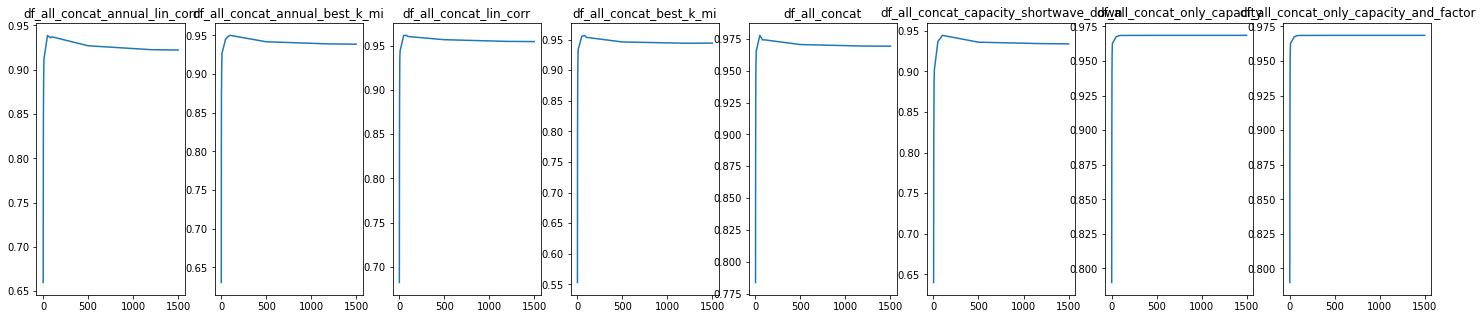

In [55]:
candidate_max_leaf_nodes = [2, 3, 4, 5, 7, 10, 50, 80, 100, 500, 1200, 1500]

# plt.figure(figsize=(25,15))
fig, ax =plt.subplots(1,len(dataframes_dict_X_y), figsize=(25,5))
for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    results = {}
    results = {node: utils.get_accuracy_tree("regression",node, df_X_y['X_train'], df_X_y['X_test'], df_X_y['y_train'], df_X_y['y_test']) for node in candidate_max_leaf_nodes}
    best_tree_size = max(results, key=results.get)
    print(f'{k} best_tree_size: {best_tree_size}')
    dataframes_dict_X_y[k]['best_tree_size'] = best_tree_size
    ax[i].set_title(k)
    sns.lineplot(data=results, x= results.keys(), y= results.values(), ax=ax[i])

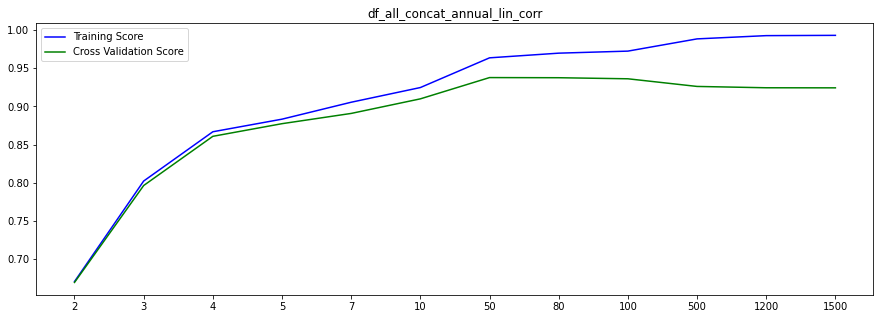

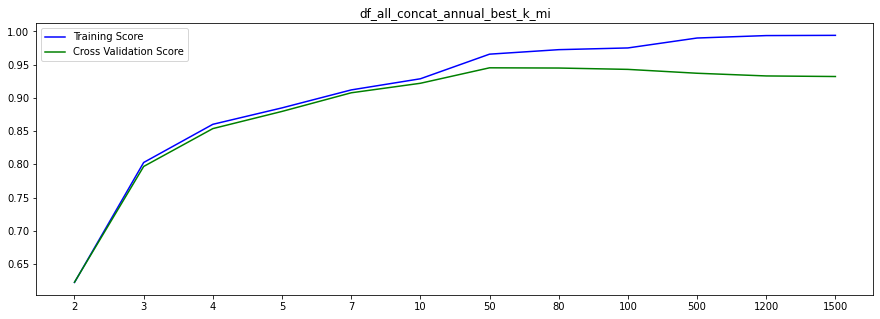

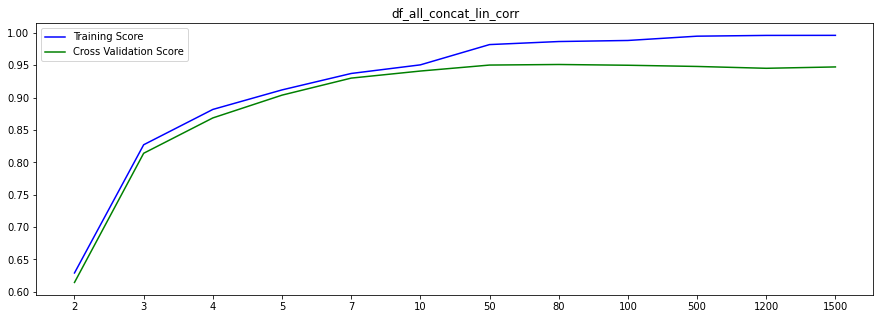

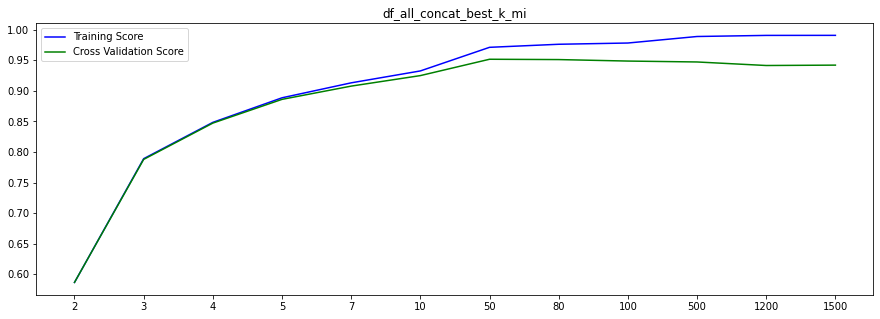

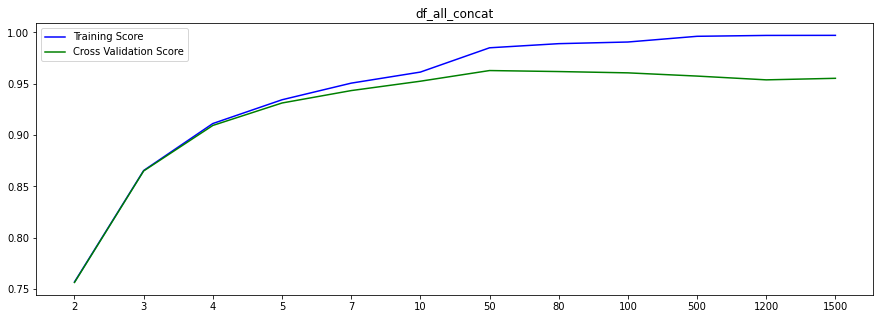

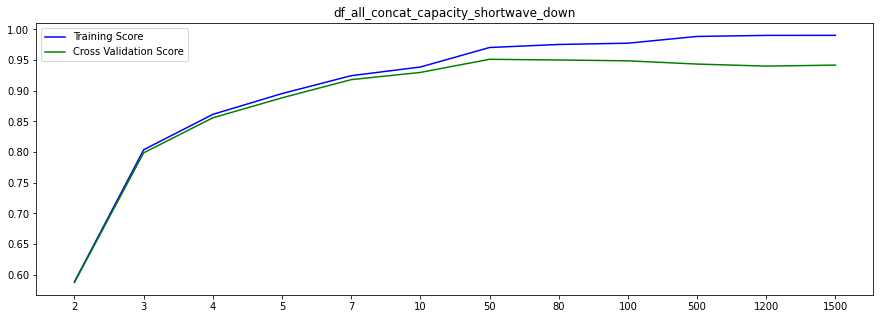

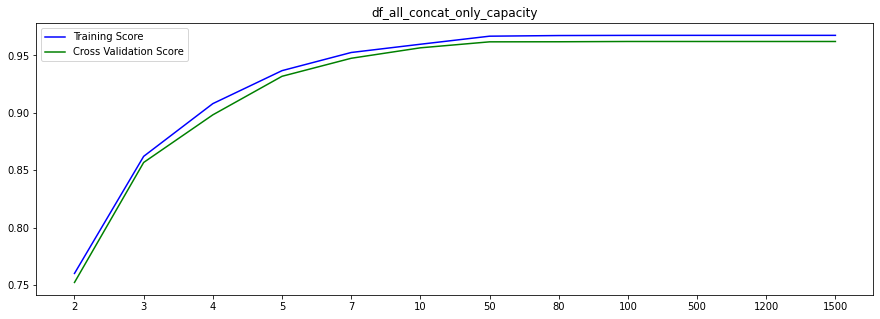

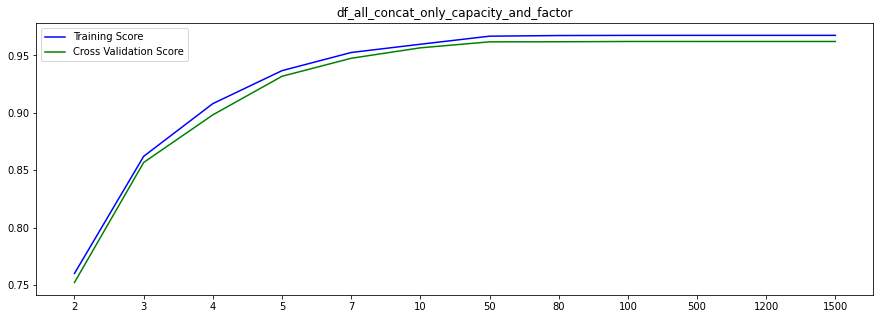

In [56]:
for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    utils.validation_curve_plot(k, DecisionTreeRegressor(), df_X_y['X_train'], df_X_y['y_train'], 'max_leaf_nodes', np.array(candidate_max_leaf_nodes))

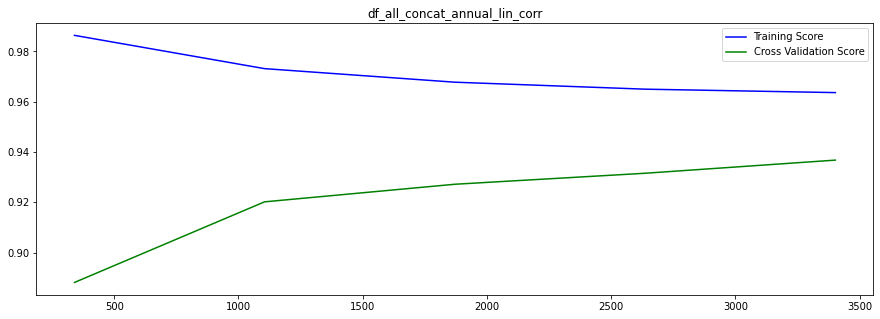

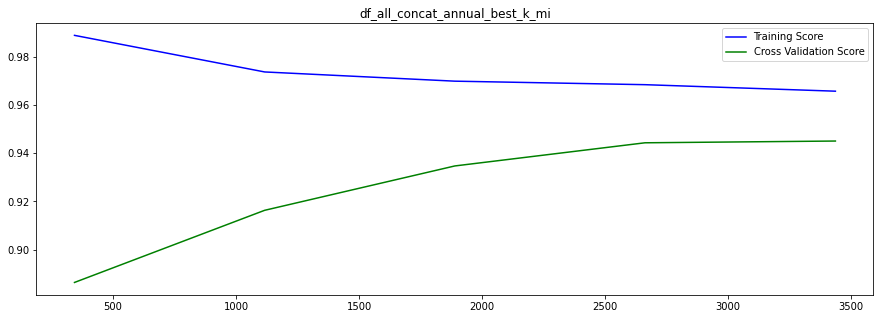

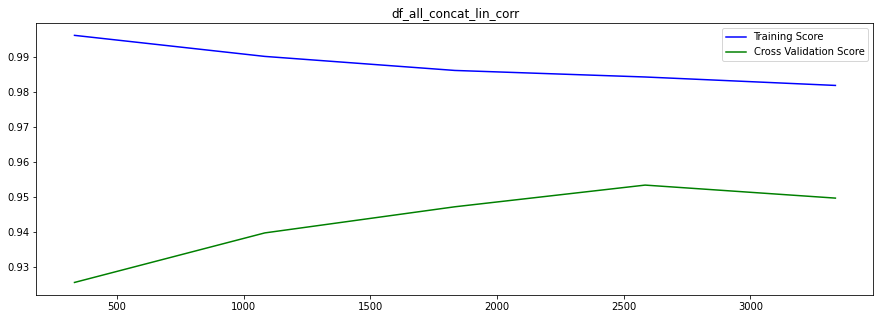

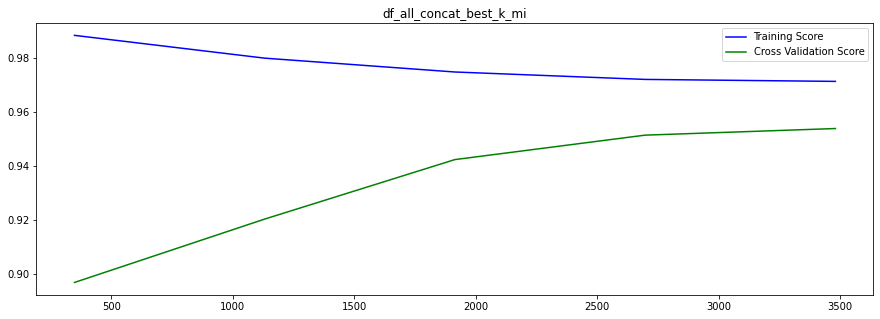

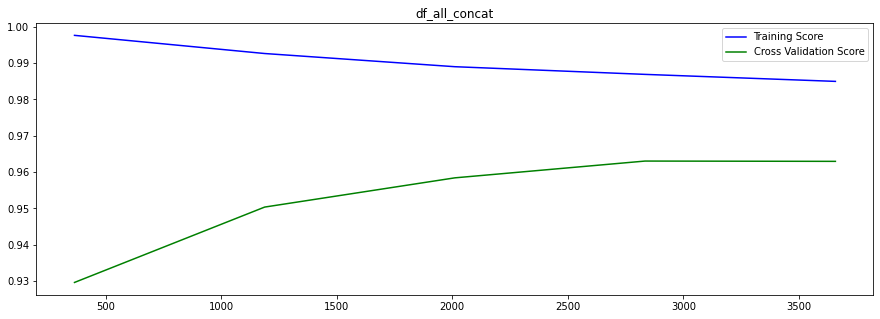

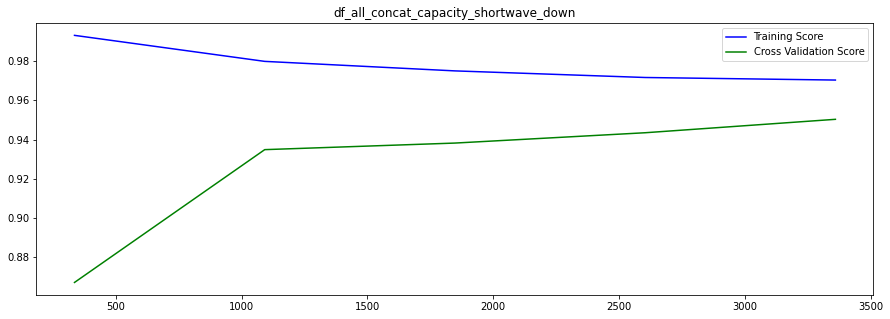

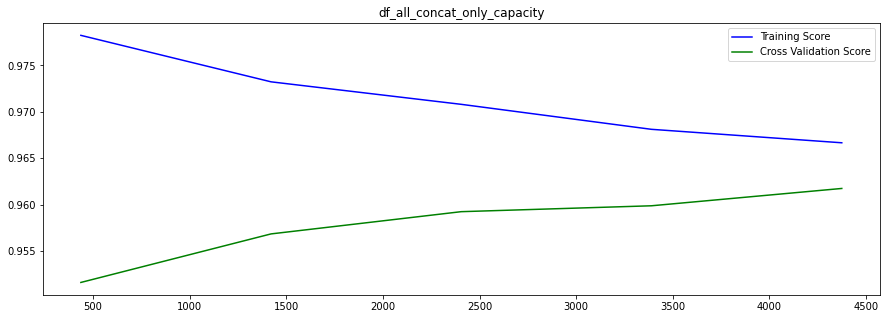

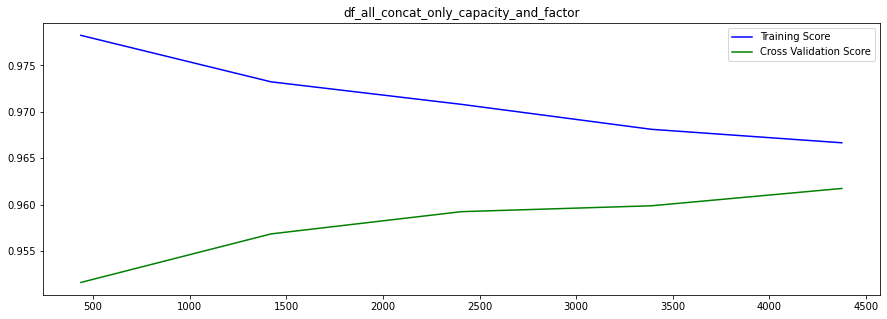

In [57]:
for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    utils.learning_curve_plot(k, DecisionTreeRegressor(max_leaf_nodes=50),df_X_y['X_train'], df_X_y['y_train'])

In [58]:
for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    results = utils.performance_metrics_cross_val(df_X_y['X_train'], df_X_y['y_train'], DecisionTreeRegressor(max_leaf_nodes=50), k)
    print(k)
    print(results)

df_all_concat_annual_lin_corr
{'test_r2': 0.9376130520675486, 'test_mean_squared_error': 0.9182841947141984, 'test_mean_absolute_error': 0.5964421448630055, 'test_root_mean_squared_error': 0.9546642847938285}
df_all_concat_annual_best_k_mi
{'test_r2': 0.942513629356486, 'test_mean_squared_error': 0.9862127054589092, 'test_mean_absolute_error': 0.6122387145938587, 'test_root_mean_squared_error': 0.9924858257574016}
df_all_concat_lin_corr
{'test_r2': 0.9501168578471182, 'test_mean_squared_error': 2.4303125463736426, 'test_mean_absolute_error': 0.7902112419448588, 'test_root_mean_squared_error': 1.5445941325539134}
df_all_concat_best_k_mi
{'test_r2': 0.9535653640077426, 'test_mean_squared_error': 0.9419842953774488, 'test_mean_absolute_error': 0.6120236911275897, 'test_root_mean_squared_error': 0.9694304388108573}
df_all_concat
{'test_r2': 0.9622211129600033, 'test_mean_squared_error': 3.572715501771577, 'test_mean_absolute_error': 0.9351982548827709, 'test_root_mean_squared_error': 1.881

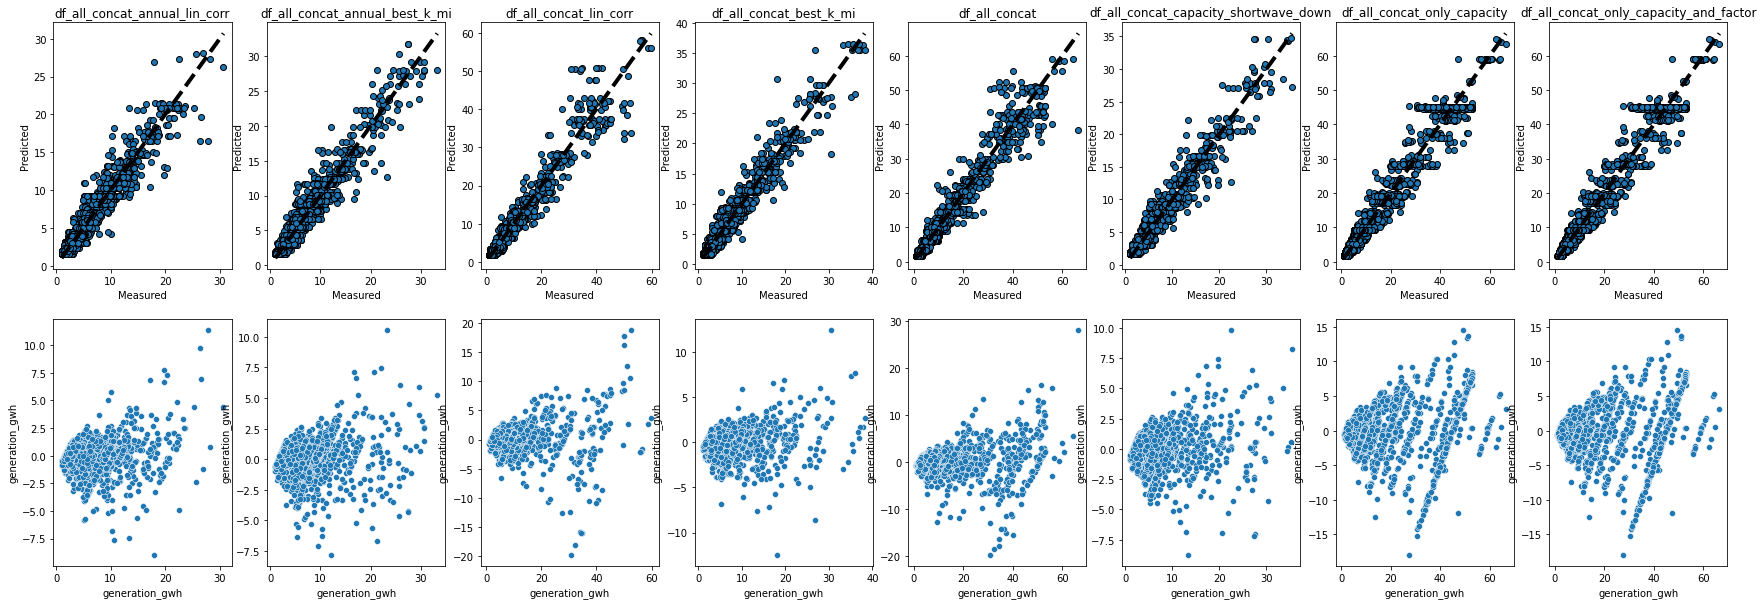

In [59]:

fig, ax =plt.subplots(2,len(dataframes_dict_X_y), figsize=(30,10))

for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    predicted = cross_val_predict(DecisionTreeRegressor(max_leaf_nodes=50), df_X_y['X_train'], df_X_y['y_train'], cv=5)
    # fig, ax = plt.subplots()
    ax[0,i].scatter(df_X_y['y_train'], predicted, edgecolors=(0, 0, 0))
    ax[0,i].plot([df_X_y['y_train'].min(), df_X_y['y_train'].max()], [df_X_y['y_train'].min(), df_X_y['y_train'].max()], "k--", lw=4)
    ax[0,i].set_xlabel("Measured")
    ax[0,i].set_ylabel("Predicted")
    ax[0,i].set_title(k)
    # plt.show()

    residuals = df_X_y['y_train'] - predicted
    sns.scatterplot(x=df_X_y['y_train'], y=residuals, ax=ax[1, i])

# RANDOM FOREST REGRESSOR

In [58]:
# Numbers of trees
n_estimators = [int(x) for x in np.arange(10, 101, 10)]
# Numbers of features to consider at every split
# max_features = [1, "sqrt", "log2"]
# Maximum numbers of levels in tree
max_depth = [int(x) for x in np.arange(10, 501, 10)]
# Minimum numbers of samples required to split a node
min_samples_split = [int(x) for x in np.arange(10, 51, 10)]
# Minimum numbers of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.arange(5, 101, 5)]
# Method of selecting samples for training each tree
bootstrap = [True, False]

max_leaf_nodes = [int(x) for x in np.arange(10, 501, 10)]

param_grid = {
                'n_estimators': n_estimators,
                # 'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': bootstrap,
                'max_leaf_nodes': max_leaf_nodes
            }



In [59]:

# rf_grid = GridSearchCV(estimator = RandomForestRegressor(), param_grid = param_grid, cv=5, verbose = 2, n_jobs=4)
rf_grid = RandomizedSearchCV(estimator = RandomForestRegressor(), param_distributions = param_grid, n_iter = 50, cv=5, verbose = 2, n_jobs=4)

In [60]:
rf_grid.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'])

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END bootstrap=False, max_depth=470, max_leaf_nodes=360, min_samples_leaf=95, min_samples_split=10, n_estimators=100; total time=   9.9s
[CV] END bootstrap=False, max_depth=470, max_leaf_nodes=360, min_samples_leaf=95, min_samples_split=10, n_estimators=100; total time=   9.8s
[CV] END bootstrap=False, max_depth=470, max_leaf_nodes=360, min_samples_leaf=95, min_samples_split=10, n_estimators=100; total time=   9.7s
[CV] END bootstrap=False, max_depth=470, max_leaf_nodes=360, min_samples_leaf=95, min_samples_split=10, n_estimators=100; total time=  10.0s
[CV] END bootstrap=True, max_depth=430, max_leaf_nodes=430, min_samples_leaf=20, min_samples_split=30, n_estimators=50; total time=   3.8s
[CV] END bootstrap=True, max_depth=430, max_leaf_nodes=430, min_samples_leaf=20, min_samples_split=30, n_estimators=50; total time=   3.9s
[CV] END bootstrap=True, max_depth=430, max_leaf_nodes=430, min_samples_leaf=20, min_samples_spl

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=50, n_jobs=4,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110, 120,
                                                      130, 140, 150, 160, 170,
                                                      180, 190, 200, 210, 220,
                                                      230, 240, 250, 260, 270,
                                                      280, 290, 300, ...],
                                        'max_leaf_nodes': [10, 20, 30, 40, 50,
                                                           60, 70, 80, 90, 100,
                                                           110, 120, 130, 140,
                                                           150, 160, 170, 180,
                                                           190, 200, 210, 220,
                                                           230, 240, 250, 260,
                                                           270, 280, 290, 300, ...],
                                        'min_samples_leaf': [5, 10, 15, 20, 25,
                                                             30, 35, 40, 45, 50,
                                                             55, 60, 65, 70, 75,
                                                             80, 85, 90, 95,
                                                             100],
                                        'min_samples_split': [10, 20, 30, 40,
                                                              50],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100]},
                   verbose=2)

In [61]:
rf_grid.best_estimator_

RandomForestRegressor(max_depth=70, max_leaf_nodes=70, min_samples_leaf=15,
                      min_samples_split=10, n_estimators=30)

In [62]:
rf_grid.score(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'])

0.964031470269671

In [66]:
rf_model = RandomForestRegressor(max_depth=70, max_leaf_nodes=70, min_samples_leaf=15,
                      min_samples_split=10, n_estimators=30)
for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):

    # results = utils.performance_metrics_cross_val(df_X_y['X_train'], df_X_y['y_train'], rf_grid.best_estimator_, k)
    results = utils.performance_metrics_cross_val(df_X_y['X_train'], df_X_y['y_train'], rf_model, k)
    # print(df_X_y)
    print(k)
    print(results)

df_all_concat_annual_lin_corr
{'test_r2': 0.9483046262143958, 'test_mean_squared_error': 0.8837318825711303, 'test_mean_absolute_error': 0.5800238336300587, 'test_root_mean_squared_error': 0.9395733136850982}
df_all_concat_annual_best_k_mi
{'test_r2': 0.9450916598316008, 'test_mean_squared_error': 0.9749782150455809, 'test_mean_absolute_error': 0.5856242801043706, 'test_root_mean_squared_error': 0.9837411504004342}
df_all_concat_lin_corr
{'test_r2': 0.9632668481458839, 'test_mean_squared_error': 1.656943719269228, 'test_mean_absolute_error': 0.6852132473352339, 'test_root_mean_squared_error': 1.2853064611671228}
df_all_concat_best_k_mi
{'test_r2': 0.9383476569515212, 'test_mean_squared_error': 0.9099836730599449, 'test_mean_absolute_error': 0.5841809662187888, 'test_root_mean_squared_error': 0.9526169555024697}
df_all_concat
{'test_r2': 0.9648708421629388, 'test_mean_squared_error': 3.314022401121336, 'test_mean_absolute_error': 0.8888484275863672, 'test_root_mean_squared_error': 1.811

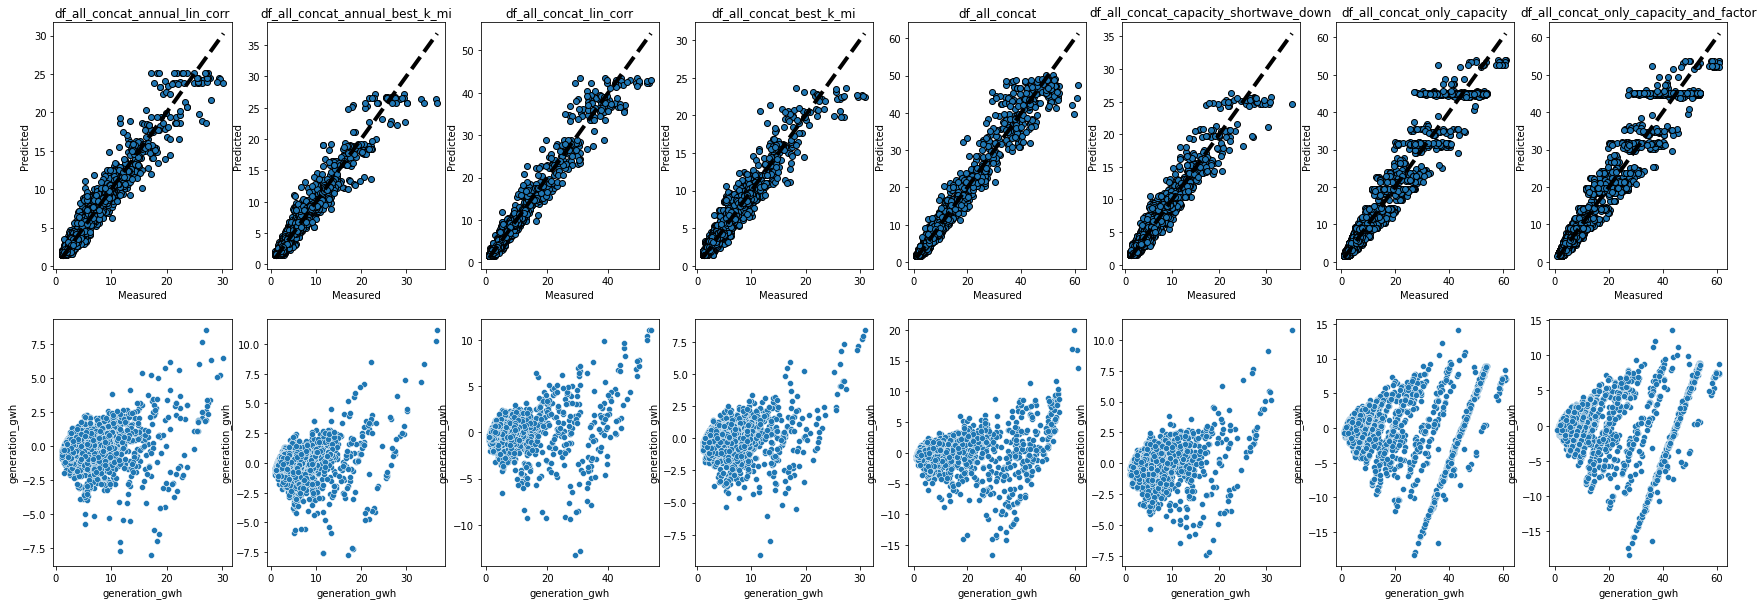

In [67]:

fig, ax =plt.subplots(2,len(dataframes_dict_X_y), figsize=(30,10))

for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    # predicted = cross_val_predict(rf_grid.best_estimator_, df_X_y['X_train'], df_X_y['y_train'], cv=5)
    predicted = cross_val_predict(rf_model, df_X_y['X_train'], df_X_y['y_train'], cv=5)
    # fig, ax = plt.subplots()
    ax[0,i].scatter(df_X_y['y_train'], predicted, edgecolors=(0, 0, 0))
    ax[0,i].plot([df_X_y['y_train'].min(), df_X_y['y_train'].max()], [df_X_y['y_train'].min(), df_X_y['y_train'].max()], "k--", lw=4)
    ax[0,i].set_xlabel("Measured")
    ax[0,i].set_ylabel("Predicted")
    ax[0,i].set_title(k)
    # plt.show()
    
    residuals = df_X_y['y_train'] - predicted
    dataframes_dict_X_y[k]['predictions'] = predicted
    dataframes_dict_X_y[k]['residuals'] = residuals
    sns.scatterplot(x=df_X_y['y_train'], y=residuals, ax=ax[1, i])

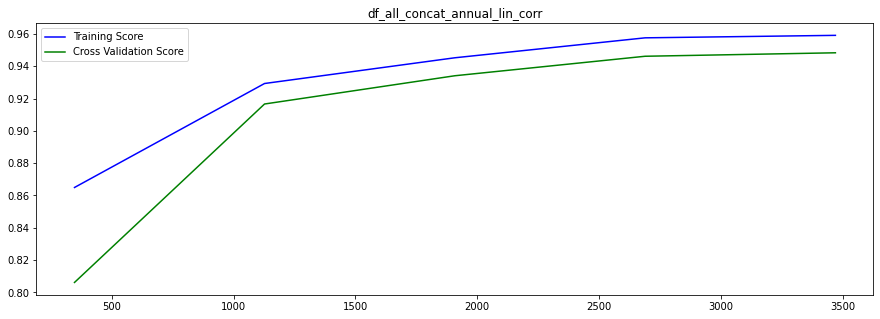

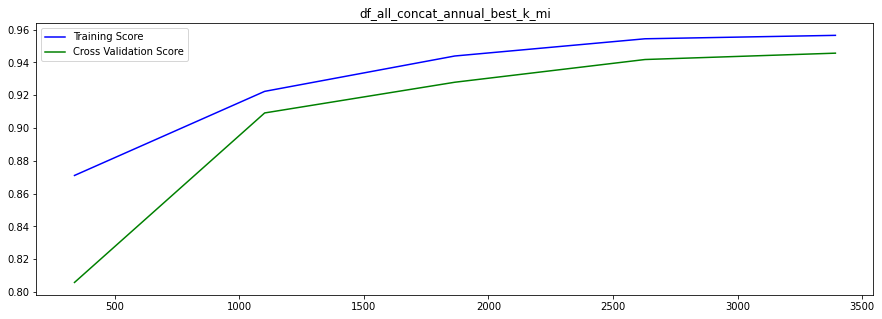

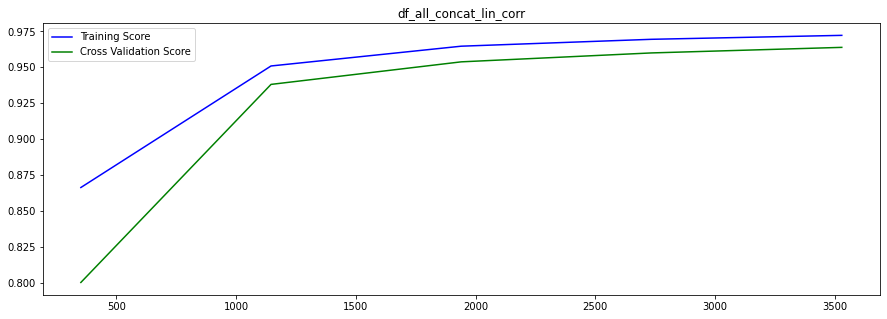

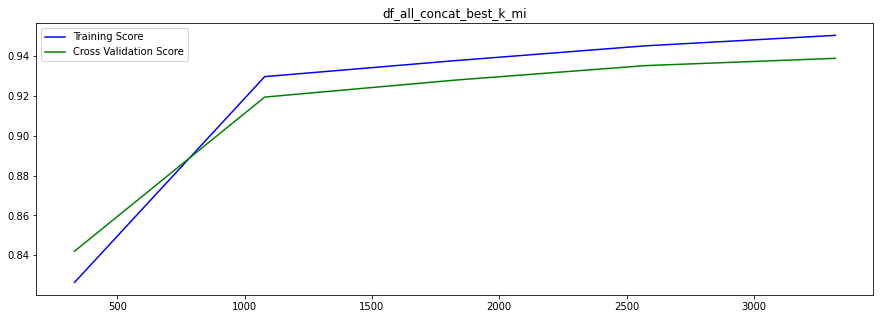

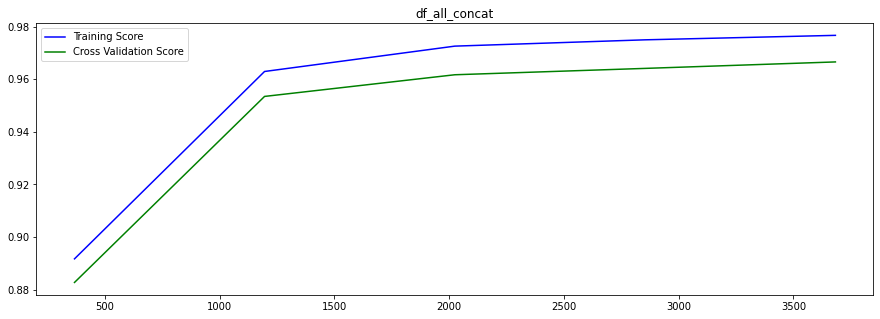

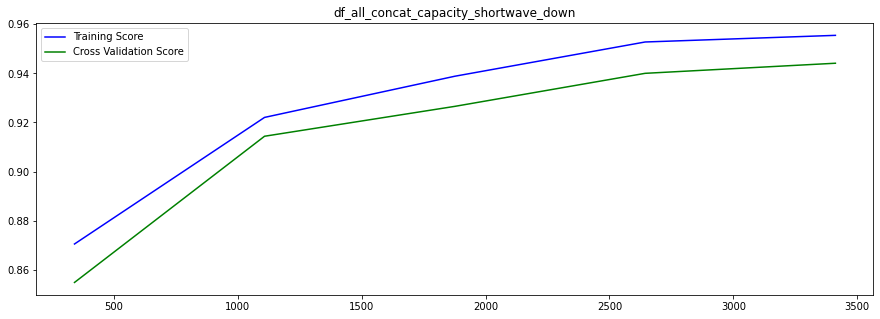

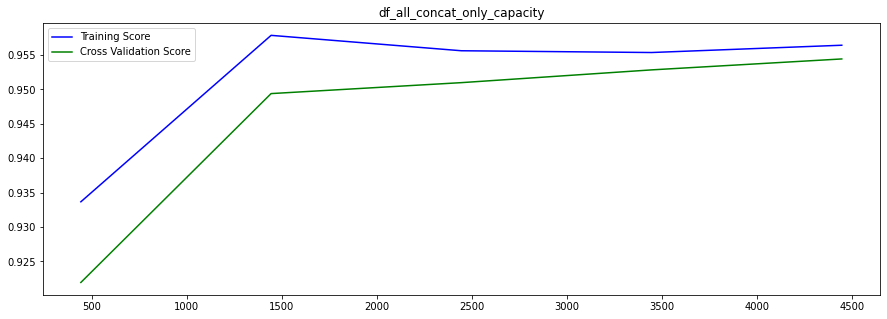

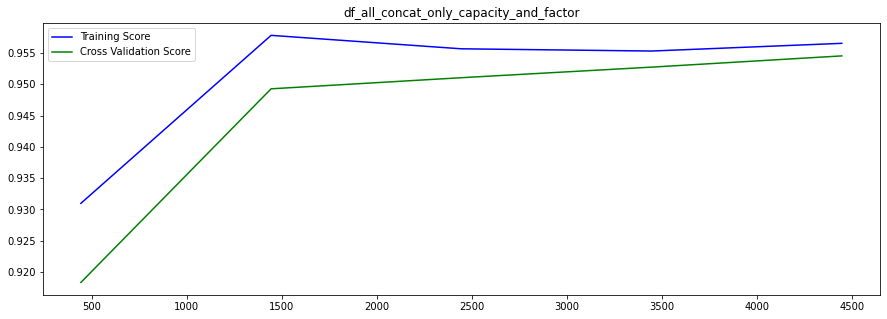

In [68]:
for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    utils.learning_curve_plot(k, rf_model,df_X_y['X_train'], df_X_y['y_train'])

# LASSO, RIDGE, LINEAR REGRESSION

In [74]:
lasso_model = Lasso(alpha=0.01)
lasso_model.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'],dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'])

ridge_model = Ridge(alpha=1)
ridge_model.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'],dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'])

linreg_model = LinearRegression()
linreg_model.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'],dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'])

y_pred = lasso_model.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'])
print("Lasso")
print(mean_absolute_error(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'], y_pred))
print(mean_squared_error(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'], y_pred))
print(lasso_model.score(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_test']))

y_pred = linreg_model.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'])
print("Linear Regression")
print(mean_absolute_error(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'], y_pred))
print(mean_squared_error(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'], y_pred))
print(linreg_model.score(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'])
)
y_pred = ridge_model.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'])
print("Ridge")
print(mean_absolute_error(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'], y_pred))
print(mean_squared_error(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'], y_pred))
print(ridge_model.score(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_test']))

/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/env_renewable_power_plants_pred/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.296e+01, tolerance: 2.516e+01
  model = cd_fast.enet_coordinate_descent(


Lasso
0.9541653650135541
2.5131178126430593
0.9569919935926456
Linear Regression
0.9520011223352874
2.4815491365110716
0.9575322411761557
Ridge
0.9519237654185976
2.4853850716175323
0.9574665952598334


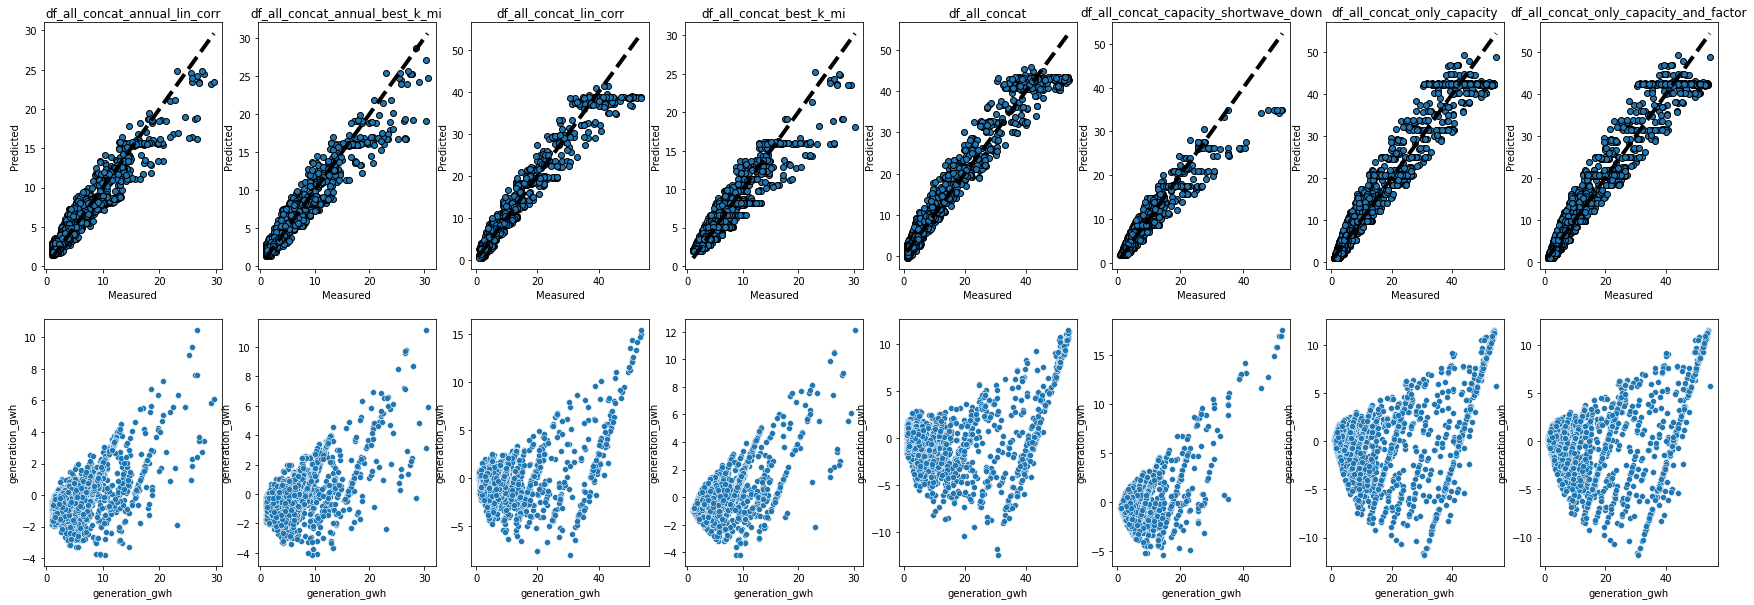

In [75]:
fig, ax =plt.subplots(2,len(dataframes_dict_X_y), figsize=(30,10))

for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    predicted = cross_val_predict(Lasso(), df_X_y['X_train'], df_X_y['y_train'], cv=5)
    # fig, ax = plt.subplots()
    ax[0,i].scatter(df_X_y['y_train'], predicted, edgecolors=(0, 0, 0))
    ax[0,i].plot([df_X_y['y_train'].min(), df_X_y['y_train'].max()], [df_X_y['y_train'].min(), df_X_y['y_train'].max()], "k--", lw=4)
    ax[0,i].set_xlabel("Measured")
    ax[0,i].set_ylabel("Predicted")
    ax[0,i].set_title(k)
    # plt.show()

    residuals = df_X_y['y_train'] - predicted
    sns.scatterplot(x=df_X_y['y_train'], y=residuals, ax=ax[1, i])


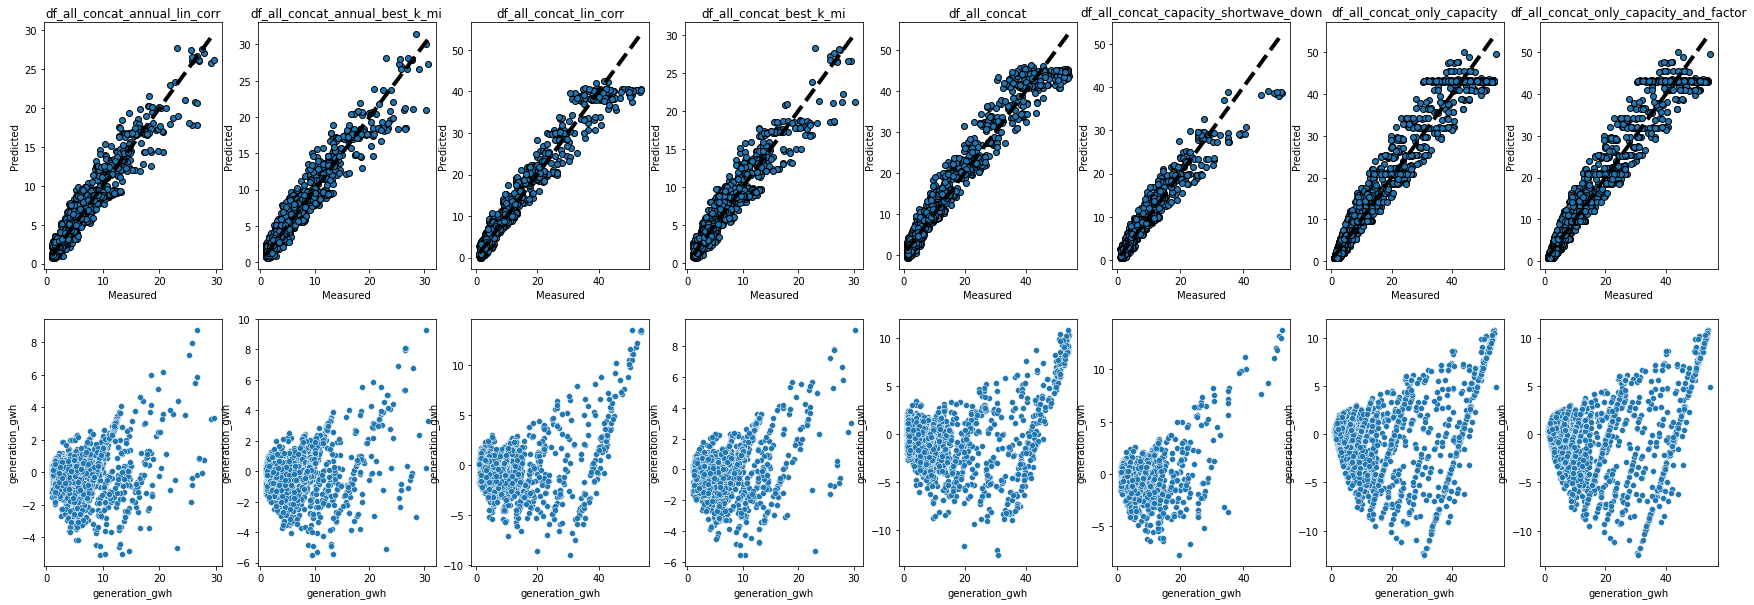

In [76]:
fig, ax =plt.subplots(2,len(dataframes_dict_X_y), figsize=(30,10))

for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    predicted = cross_val_predict(Ridge(), df_X_y['X_train'], df_X_y['y_train'], cv=5)
    # fig, ax = plt.subplots()
    ax[0,i].scatter(df_X_y['y_train'], predicted, edgecolors=(0, 0, 0))
    ax[0,i].plot([df_X_y['y_train'].min(), df_X_y['y_train'].max()], [df_X_y['y_train'].min(), df_X_y['y_train'].max()], "k--", lw=4)
    ax[0,i].set_xlabel("Measured")
    ax[0,i].set_ylabel("Predicted")
    ax[0,i].set_title(k)
    # plt.show()

    residuals = df_X_y['y_train'] - predicted
    sns.scatterplot(x=df_X_y['y_train'], y=residuals, ax=ax[1, i])

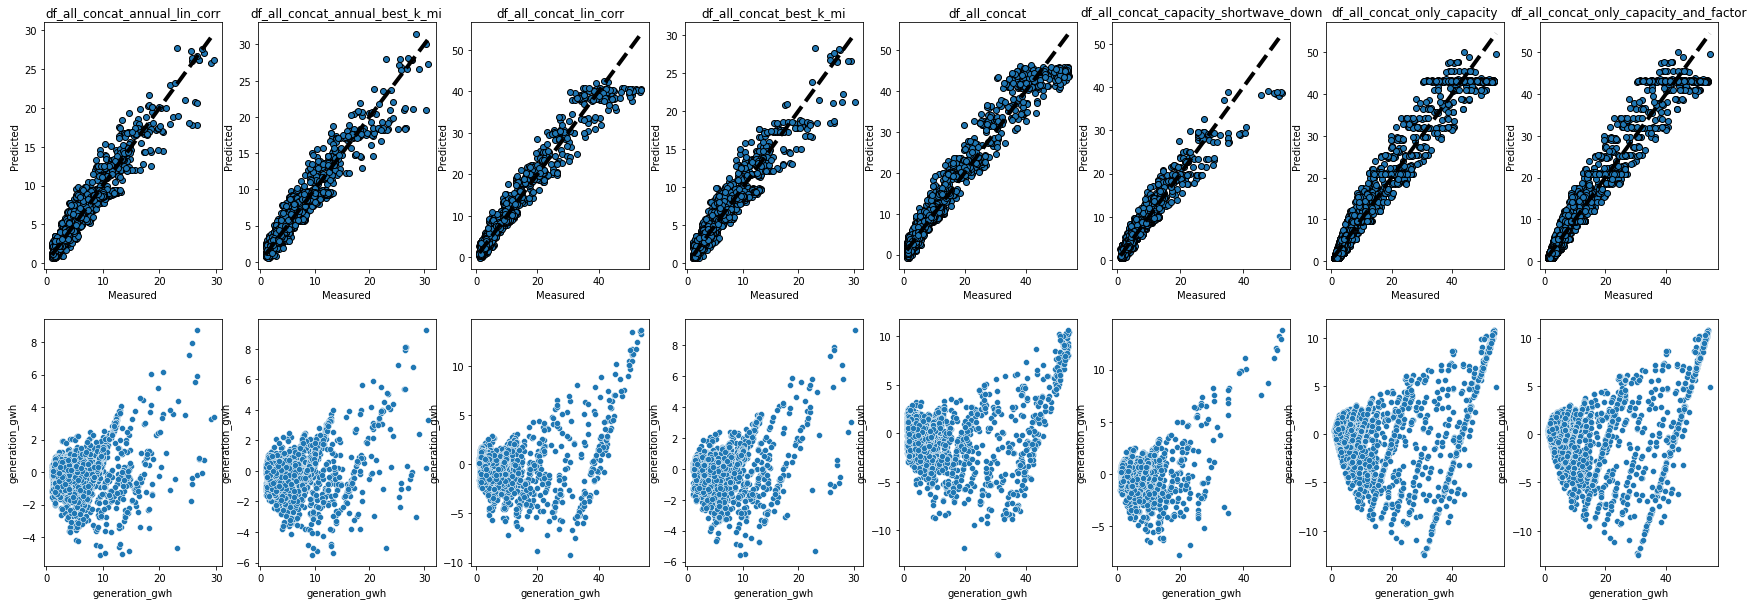

In [77]:
fig, ax =plt.subplots(2,len(dataframes_dict_X_y), figsize=(30,10))

for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    predicted = cross_val_predict(LinearRegression(), df_X_y['X_train'], df_X_y['y_train'], cv=5)
    # fig, ax = plt.subplots()
    ax[0,i].scatter(df_X_y['y_train'], predicted, edgecolors=(0, 0, 0))
    ax[0,i].plot([df_X_y['y_train'].min(), df_X_y['y_train'].max()], [df_X_y['y_train'].min(), df_X_y['y_train'].max()], "k--", lw=4)
    ax[0,i].set_xlabel("Measured")
    ax[0,i].set_ylabel("Predicted")
    ax[0,i].set_title(k)
    # plt.show()

    residuals = df_X_y['y_train'] - predicted
    sns.scatterplot(x=df_X_y['y_train'], y=residuals, ax=ax[1, i])

In [78]:
np.arange(0.01, 1.01, 0.01)

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ])

# SCALLING

In [81]:

for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):    
    # X_train_normalized = stats.boxcox(X_train)
    x = df_X_y['X_train'].values #returns a numpy array
    min_max_scaler = MinMaxScaler()
    power_transformer = PowerTransformer(method='yeo-johnson')
    standard_scaler = StandardScaler()
    # x_scaled = min_max_scaler.fit_transform(x)
    # x_scaled = power_transformer.fit_transform(x)
    x_scaled = standard_scaler.fit_transform(x)
    df_X_y['X_train_scaled'] = pd.DataFrame(x_scaled, index=df_X_y['X_train'].index, columns=df_X_y['X_train'].columns)

    x = df_X_y['X_test'].values #returns a numpy array
    # x_scaled = min_max_scaler.fit_transform(x)
    # x_scaled = power_transformer.fit_transform(x)
    x_scaled = standard_scaler.fit_transform(x)
    df_X_y['X_test_scaled'] = pd.DataFrame(x_scaled, index=df_X_y['X_test'].index, columns=df_X_y['X_test'].columns)

    x = df_X_y['X'].values #returns a numpy array
    # x_scaled = min_max_scaler.fit_transform(x)
    # x_scaled = power_transformer.fit_transform(x)
    x_scaled = standard_scaler.fit_transform(x)
    df_X_y['X_scaled'] = pd.DataFrame(x_scaled, index=df_X_y['X'].index, columns=df_X_y['X'].columns)


# KNN

df_all_concat_annual_lin_corr best_n_neighbors: 4
df_all_concat_annual_best_k_mi best_n_neighbors: 4
df_all_concat_lin_corr best_n_neighbors: 4
df_all_concat_best_k_mi best_n_neighbors: 4
df_all_concat best_n_neighbors: 3
df_all_concat_capacity_shortwave_down best_n_neighbors: 2
df_all_concat_only_capacity best_n_neighbors: 29
df_all_concat_only_capacity_and_factor best_n_neighbors: 29


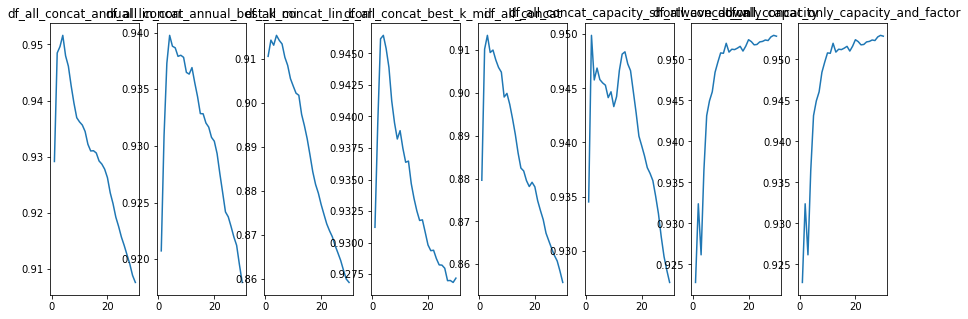

In [82]:
candidate_n_neighbors = np.arange(1,31)

# plt.figure(figsize=(25,15))
fig, ax =plt.subplots(1,len(dataframes_dict_X_y), figsize=(15,5))
for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    results = {}
    results = {node: utils.get_accuracy_knn("regression",node, df_X_y['X_train_scaled'], df_X_y['X_test_scaled'], df_X_y['y_train'], df_X_y['y_test']) for node in candidate_n_neighbors}
    best_n_neighbors = max(results, key=results.get)
    print(f'{k} best_n_neighbors: {best_n_neighbors}')
    dataframes_dict_X_y[k]['best_n_neighbors'] = best_tree_size
    ax[i].set_title(k)
    sns.lineplot(data=results, x= results.keys(), y= results.values(), ax=ax[i])


# POLYNOMIAL FEATURES

In [ ]:
polynomial_features = PolynomialFeatures(2)
polynomial_features.fit_transform(X)

In [ ]:
model_scaled_poly_knn = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(2),
    KNeighborsRegressor(n_neighbors = dataframes_dict_X_y['df_all_concat_lin_corr']['best_n_neighbors'])
)

model_scaled_poly_knn.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'])
model_scaled_poly_knn.score(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'])
y_pred = model_scaled_poly_knn.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'])
residuals = dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'] - y_pred
# ap_residuals = np.abs(residuals) / y_test
# lap_residuals = np.log(ap_residuals)

y_pred = model_scaled_poly_knn.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'])
sns.scatterplot(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'], residuals)

In [ ]:
results = cross_validate(KNeighborsRegressor(n_neighbors = 12), X, y, cv=5)
results

# VALIDATION AND LEARNING CURVE IN KNN
https://scikit-learn.org/stable/modules/learning_curve.html

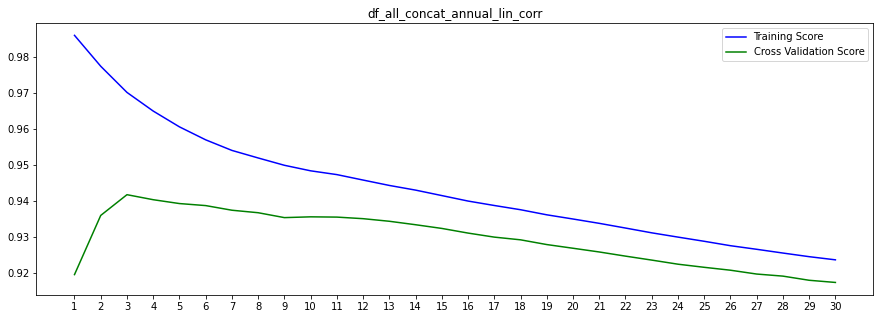

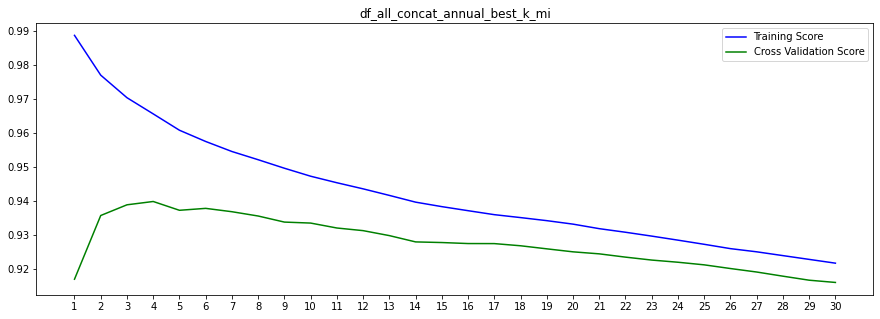

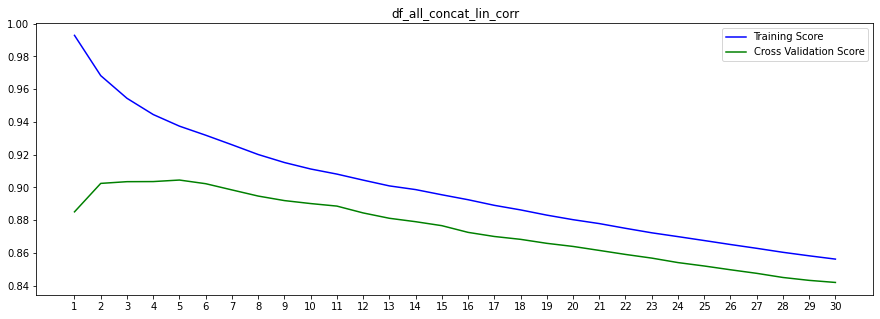

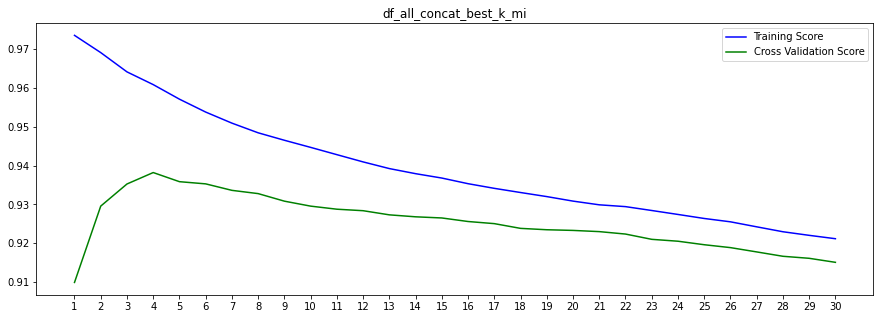

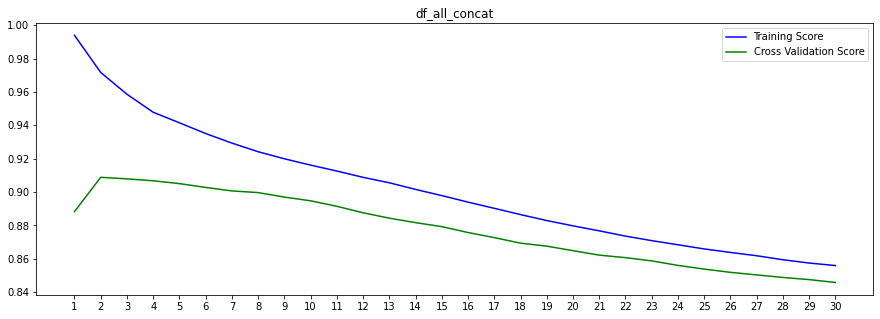

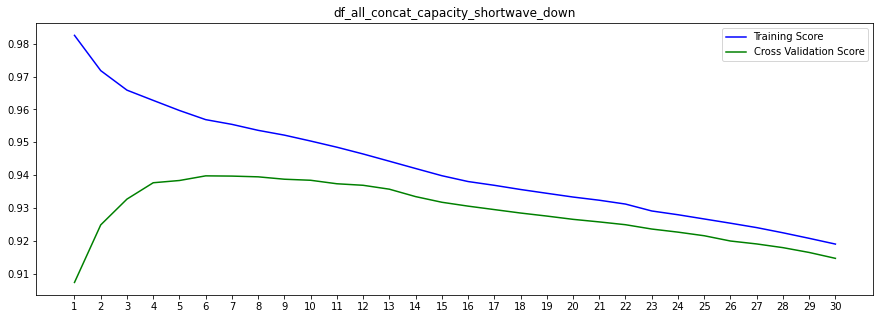

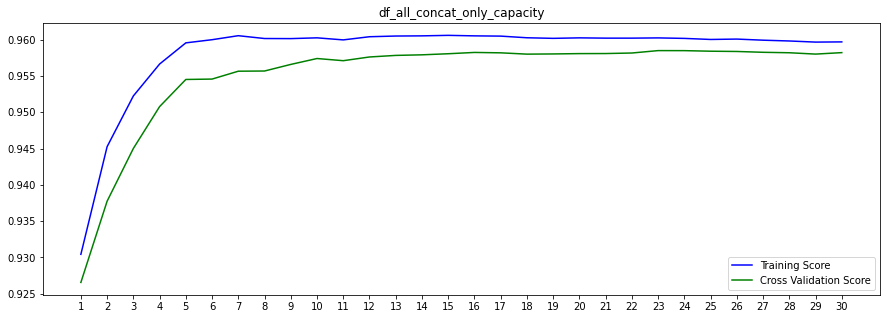

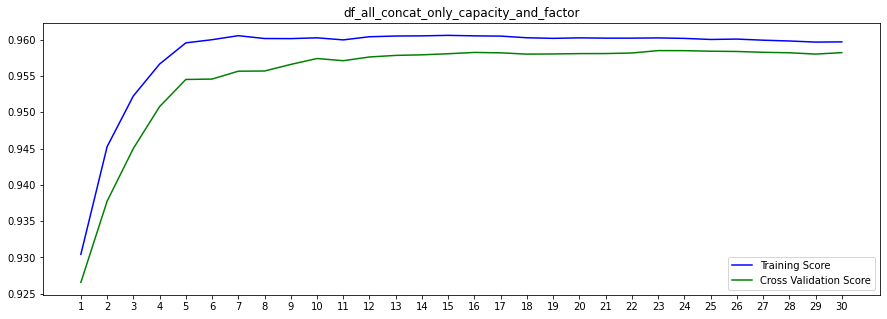

In [86]:
for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    utils.validation_curve_plot(k, KNeighborsRegressor(), df_X_y['X_train_scaled'], df_X_y['y_train'], 'n_neighbors', np.array(candidate_n_neighbors))

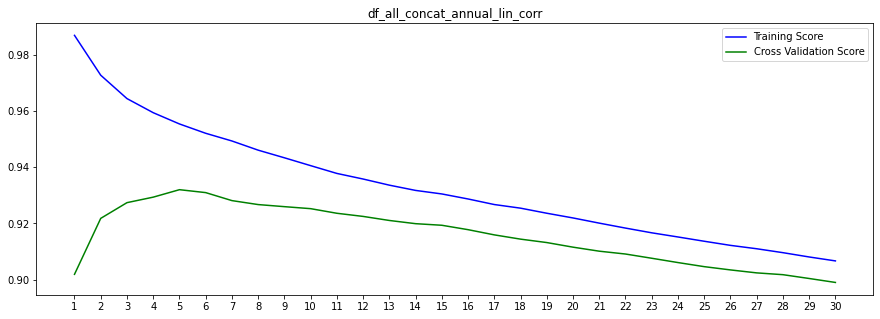

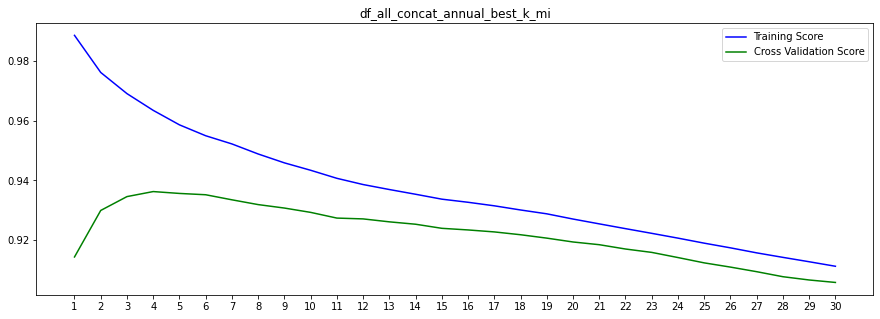

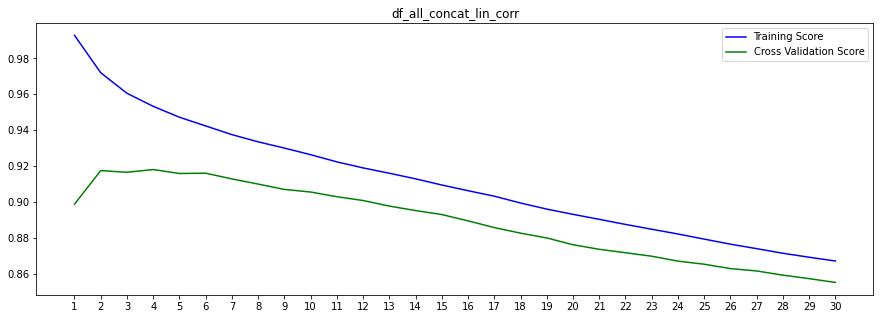

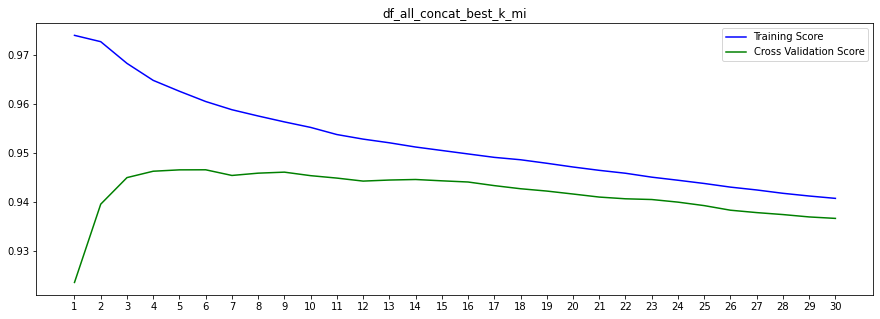

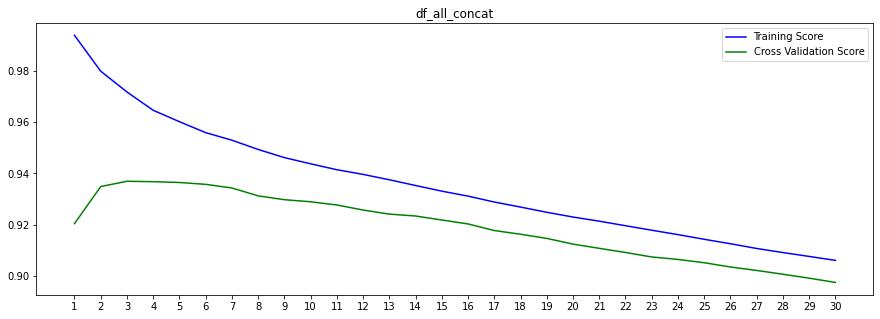

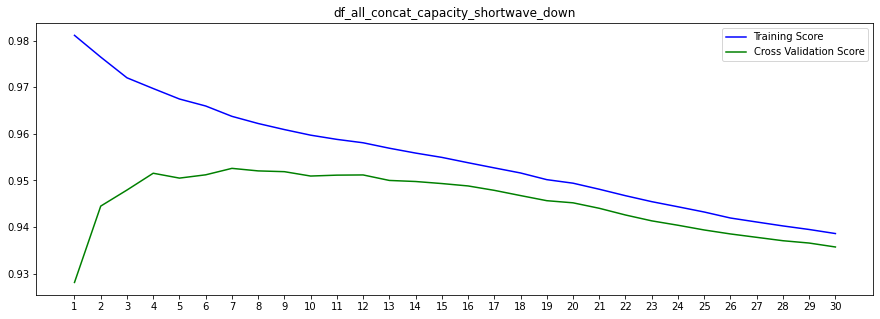

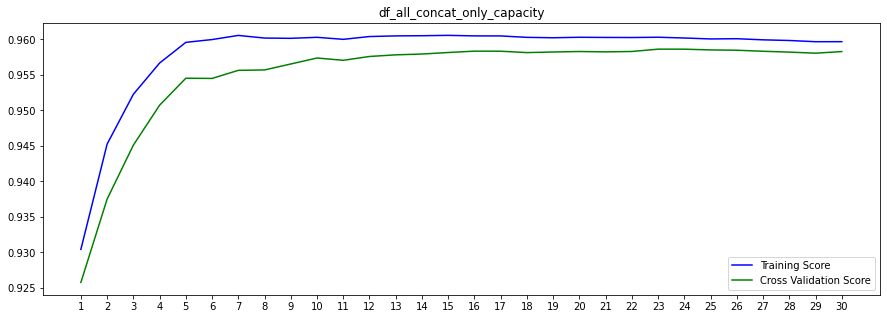

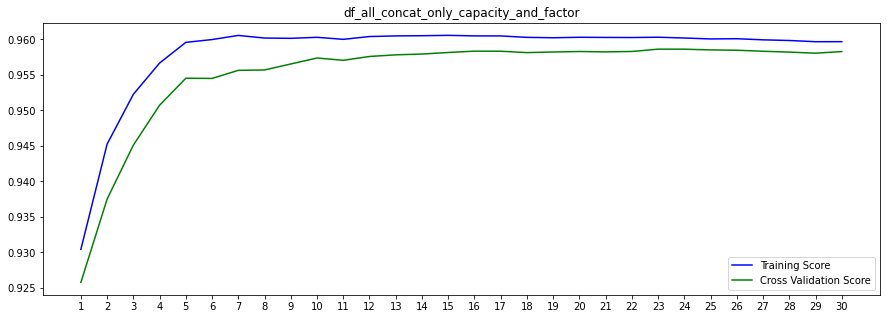

In [90]:
for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    utils.validation_curve_plot(k, KNeighborsRegressor(), df_X_y['X_train'], df_X_y['y_train'], 'n_neighbors', np.array(candidate_n_neighbors))

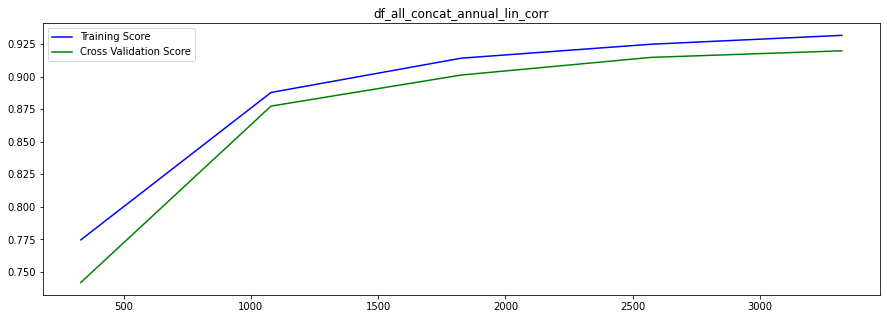

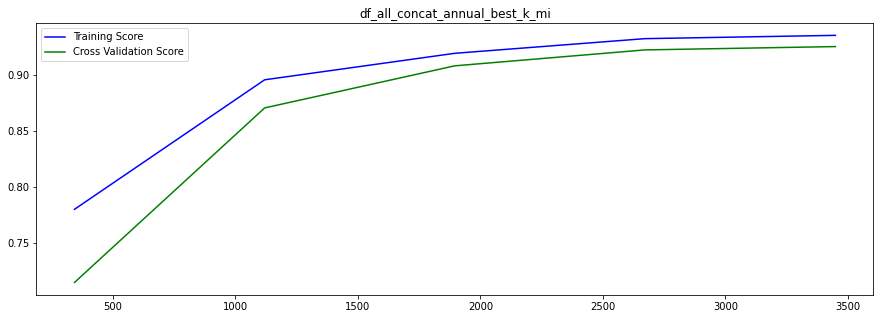

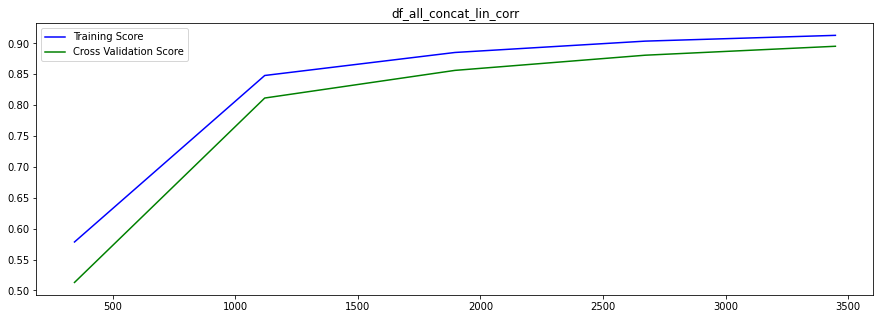

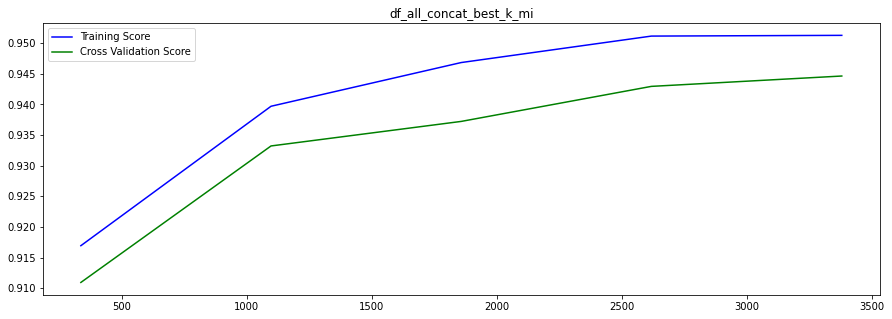

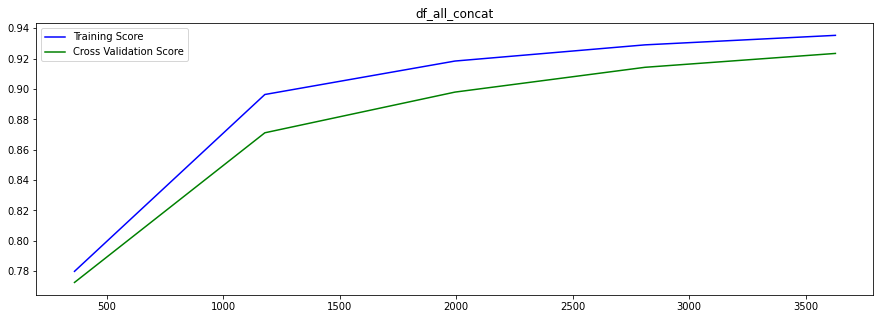

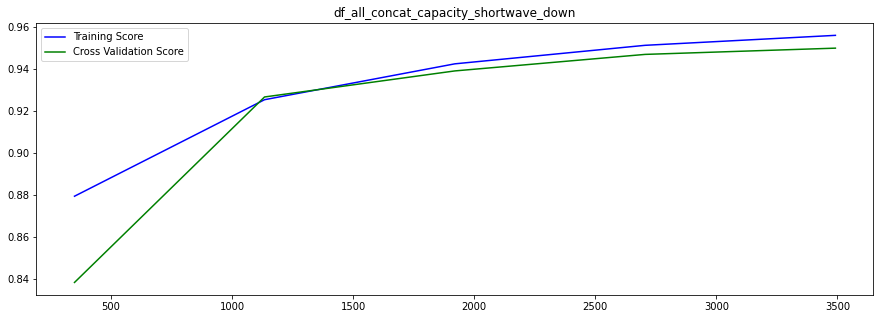

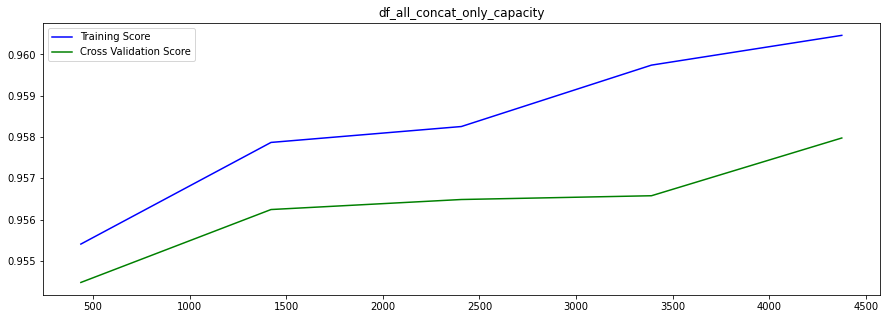

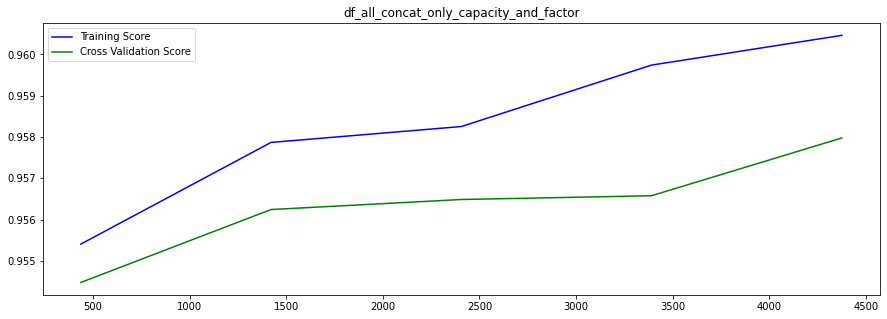

In [91]:
for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    utils.learning_curve_plot(k, KNeighborsRegressor(n_neighbors=14),df_X_y['X_train'], df_X_y['y_train'])

In [ ]:

fig, ax =plt.subplots(2,len(dataframes_dict_X_y), figsize=(30,10))

for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    predicted = cross_val_predict(KNeighborsRegressor(n_neighbors=14), df_X_y['X_train_scaled'], df_X_y['y_train'], cv=5)
    # fig, ax = plt.subplots()
    ax[0,i].scatter(df_X_y['y_train'], predicted, edgecolors=(0, 0, 0))
    ax[0,i].plot([df_X_y['y_train'].min(), df_X_y['y_train'].max()], [df_X_y['y_train'].min(), df_X_y['y_train'].max()], "k--", lw=4)
    ax[0,i].set_xlabel("Measured")
    ax[0,i].set_ylabel("Predicted")
    ax[0,i].set_title(k)
    # plt.show()

    residuals = df_X_y['y_train'] - predicted
    sns.scatterplot(x=df_X_y['y_train'], y=residuals, ax=ax[1, i])

In [ ]:

fig, ax =plt.subplots(2,len(dataframes_dict_X_y), figsize=(30,10))

for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    predicted = cross_val_predict(KNeighborsRegressor(n_neighbors=14), df_X_y['X_train'], df_X_y['y_train'], cv=5)
    # fig, ax = plt.subplots()
    ax[0,i].scatter(df_X_y['y_train'], predicted, edgecolors=(0, 0, 0))
    ax[0,i].plot([df_X_y['y_train'].min(), df_X_y['y_train'].max()], [df_X_y['y_train'].min(), df_X_y['y_train'].max()], "k--", lw=4)
    ax[0,i].set_xlabel("Measured")
    ax[0,i].set_ylabel("Predicted")
    ax[0,i].set_title(k)
    # plt.show()

    residuals = df_X_y['y_train'] - predicted
    sns.scatterplot(x=df_X_y['y_train'], y=residuals, ax=ax[1, i])

In [ ]:
for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    results = utils.performance_metrics_cross_val(df_X_y['X_train_scaled'], df_X_y['y_train'], KNeighborsRegressor(n_neighbors = 14), k)
    print(k)
    print(results)

In [ ]:
knn_model = KNeighborsRegressor(n_neighbors = 14)
knn_model.fit(dataframes_dict_X_y['df_all_concat_best_k_mi']['X_train'], dataframes_dict_X_y['df_all_concat_best_k_mi']['y_train'])
y_pred = knn_model.predict(dataframes_dict_X_y['df_all_concat_best_k_mi']['X_test'])
residuals = dataframes_dict_X_y['df_all_concat_best_k_mi']['y_test'] - y_pred
utils.adjusted_r2(dataframes_dict_X_y['df_all_concat_best_k_mi']['X_train'], dataframes_dict_X_y['df_all_concat_best_k_mi']['y_test'], y_pred)
print(r2_score(dataframes_dict_X_y['df_all_concat_best_k_mi']['y_test'], y_pred))
# y_pred = model_poly_knn.predict(X_test)
sns.scatterplot(dataframes_dict_X_y['df_all_concat_best_k_mi']['y_test'], residuals)

# PREDICTION INTERVALS
https://mapie.readthedocs.io/en/latest/tutorial_regression.html
https://andrewpwheeler.com/2022/02/04/prediction-intervals-for-random-forests/
https://stats.stackexchange.com/questions/85560/shape-of-confidence-interval-for-predicted-values-in-linear-regression
https://saattrupdan.github.io/2020-03-01-bootstrap-prediction/
https://medium.com/@qucit/a-simple-technique-to-estimate-prediction-intervals-for-any-regression-model-2dd73f630bcb

## Intervals with Gradient Tree Boosting

In [ ]:
# Numbers of trees
n_estimators = [int(x) for x in np.arange(10, 101, 10)]
# Numbers of features to consider at every split
# max_features = [1, "sqrt", "log2"]
# Maximum numbers of levels in tree
max_depth = [int(x) for x in np.arange(10, 501, 10)]
# Minimum numbers of samples required to split a node
min_samples_split = [int(x) for x in np.arange(10, 51, 10)]
# Minimum numbers of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.arange(5, 101, 5)]
# Method of selecting samples for training each tree
# bootstrap = [True, False]

max_leaf_nodes = [int(x) for x in np.arange(10, 501, 10)]

learning_rate = [np.around(x,3) for x in np.arange(0.005, 2.001, 0.005)]

param_grid = {
                'n_estimators': n_estimators,
                # 'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                # 'bootstrap': bootstrap,
                'max_leaf_nodes': max_leaf_nodes,
                'learning_rate': learning_rate
            }



In [ ]:
gbr_grid = RandomizedSearchCV(estimator = GradientBoostingRegressor(), param_distributions = param_grid, n_iter = 30, cv=5, verbose = 2, n_jobs=4)

In [ ]:
gbr_grid.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'])

In [ ]:
gbr_grid.best_estimator_

In [ ]:
gbr_grid.score(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'])

In [ ]:
LOWER_ALPHA = 0.05
UPPER_ALPHA = 0.95

In [ ]:
neg_mean_pinball_loss_05p_scorer = make_scorer(
    mean_pinball_loss,
    alpha=LOWER_ALPHA,
    greater_is_better=False,  # maximize the negative loss
)
neg_mean_pinball_loss_95p_scorer = make_scorer(
    mean_pinball_loss,
    alpha=UPPER_ALPHA,
    greater_is_better=False,  # maximize the negative loss
)

In [ ]:
LOWER_ALPHA = 0.05
UPPER_ALPHA = 0.95

param_grid_lower = param_grid.copy()
# param_grid_lower['loss'] = 'quantile'
# param_grid_lower['alpha'] = LOWER_ALPHA

param_grid_upper = param_grid.copy()
# param_grid_upper['loss'] = 'quantile'
# param_grid_upper['alpha'] = UPPER_ALPHA

### Lower

In [ ]:
gbr_grid_lower = RandomizedSearchCV(estimator = GradientBoostingRegressor(loss='quantile', alpha=LOWER_ALPHA), param_distributions = param_grid_lower, n_iter = 30, cv=5, verbose = 2, n_jobs=4, scoring=neg_mean_pinball_loss_05p_scorer)

In [ ]:
gbr_grid_lower.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'])

In [ ]:
gbr_grid_lower.best_estimator_

In [ ]:
gbr_grid_lower.score(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'])

### Upper

In [ ]:
gbr_grid_upper = RandomizedSearchCV(estimator = GradientBoostingRegressor(loss='quantile', alpha=UPPER_ALPHA), param_distributions = param_grid_upper, n_iter = 30, cv=5, verbose = 2, n_jobs=4, scoring=neg_mean_pinball_loss_95p_scorer)

In [ ]:
gbr_grid_upper.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'])

In [ ]:
gbr_grid_upper.best_estimator_

In [ ]:
gbr_grid_upper.score(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'])

In [ ]:
# Set lower and upper quantile


# N_ESTIMATORS = 100
# MAX_DEPTH = 5

# Each model has to be separate
GradientBoostingRegressor(alpha=0.05, learning_rate=0.385, loss='quantile',
                          max_depth=260, max_leaf_nodes=430,
                          min_samples_leaf=50, min_samples_split=20,
                          n_estimators=60)
lower_model = GradientBoostingRegressor(loss="quantile", alpha=LOWER_ALPHA, learning_rate=0.245, max_depth=430,
                          max_leaf_nodes=300, min_samples_leaf=10,
                          min_samples_split=20, n_estimators=70)
# The mid model will use the default
# mid_model = GradientBoostingRegressor(learning_rate=0.245, max_depth=430,
#                           max_leaf_nodes=300, min_samples_leaf=10,
#                           min_samples_split=20, n_estimators=70)
mean_model = GradientBoostingRegressor(learning_rate=0.245, max_depth=430,
                          max_leaf_nodes=300, min_samples_leaf=10,
                          min_samples_split=20, n_estimators=70)
# mid_model = GradientBoostingRegressor(n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH)

upper_model = GradientBoostingRegressor(alpha=0.95, learning_rate=0.155, loss='quantile',
                          max_depth=350, max_leaf_nodes=320,
                          min_samples_leaf=60, min_samples_split=30,
                          n_estimators=90)

In [ ]:
_ = lower_model.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'])
_ = mid_model.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'])
_ = upper_model.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'])

In [ ]:
predictions = pd.DataFrame(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'])
predictions['lower'] = lower_model.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'])
predictions['mid'] = mid_model.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'])
predictions['upper'] = upper_model.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'])
predictions['mean'] = mean_model.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'])


# assert (predictions['upper'] > predictions['lower']).all()

predictions.tail()

In [ ]:
predictions['upper'] > predictions['lower']

In [ ]:
predictions[(predictions['lower'] > predictions['upper'])]

In [ ]:
predictions[(predictions['lower'] > predictions['mid'])].count()

In [ ]:
predictions[(predictions['mid'] > predictions['upper'])].count()

In [ ]:
dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'][7491]

In [ ]:
fig = plt.figure(figsize=(30, 15))

# order = np.argsort(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'].values)
# plt.plot(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'], f(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test']), "g:", linewidth=3, label=r"$f(x) = x\,\sin(x)$")
plt.plot(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'].values,  predictions['mid'], "b.", markersize=10, label="Test observations")
# plt.plot(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'].values, predictions['mid'], "r-", label="Predicted mean")
# plt.plot(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'].values, predictions, "r-", label="Predicted mean")
plt.plot(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'].values, predictions['upper'], "k*")
plt.plot(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'].values, predictions['lower'], "r*")
# plt.fill_between(
#     dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'].values.ravel(), predictions['lower'], predictions['upper'], alpha=0.4, label="Predicted 90% interval"
# )
# plt.xlabel("$x$")
# plt.ylabel("$f(x)$")
# plt.ylim(-10, 25)
# plt.legend(loc="upper left")
plt.show()

In [ ]:
def coverage_fraction(y, y_low, y_high):
    return np.mean(np.logical_and(y >= y_low, y <= y_high))


coverage_fraction(
    dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'],
    lower_model.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train']),
    upper_model.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train']),
)

In [ ]:
order

In [ ]:
dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'].values[order]

In [ ]:

fig, ax =plt.subplots(2,len(dataframes_dict_X_y), figsize=(30,10))

for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    # predicted = cross_val_predict(rf_grid.best_estimator_, df_X_y['X_train'], df_X_y['y_train'], cv=5)
    predicted = cross_val_predict(mid_model, df_X_y['X_train'], df_X_y['y_train'], cv=5)
    # fig, ax = plt.subplots()
    ax[0,i].scatter(df_X_y['y_train'], predicted, edgecolors=(0, 0, 0))
    ax[0,i].plot([df_X_y['y_train'].min(), df_X_y['y_train'].max()], [df_X_y['y_train'].min(), df_X_y['y_train'].max()], "k--", lw=4)
    ax[0,i].set_xlabel("Measured")
    ax[0,i].set_ylabel("Predicted")
    ax[0,i].set_title(k)
    # plt.show()

    residuals = df_X_y['y_train'] - predicted
    sns.scatterplot(x=df_X_y['y_train'], y=residuals, ax=ax[1, i])

In [ ]:
for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    utils.learning_curve_plot(k, mid_model,df_X_y['X_train'], df_X_y['y_train'])

In [ ]:
rf_model = rf_grid.best_estimator_
# XX, yy = make_regression(n_samples=500, n_features=1, noise=20, random_state=59)

In [ ]:
rf_model.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'])

In [ ]:
predictions_try = rf_model.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'])

predictions_try

## Quantile Regressor on between y real values and y predicted values

<AxesSubplot:xlabel='generation_gwh', ylabel='generation_gwh'>

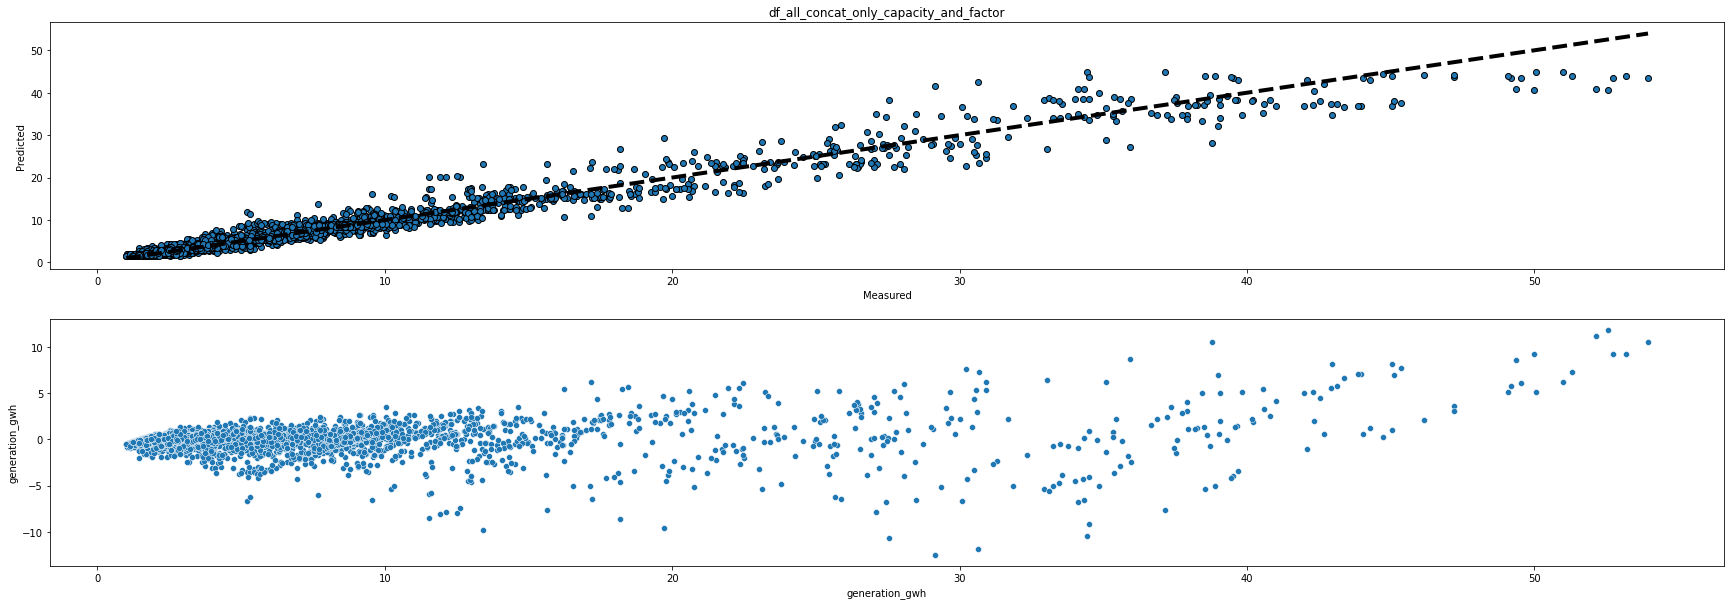

In [69]:

fig, ax =plt.subplots(2, figsize=(30,10))

# for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
# predicted = cross_val_predict(rf_grid.best_estimator_, df_X_y['X_train'], df_X_y['y'], cv=5)
predicted = cross_val_predict(rf_model, dataframes_dict_X_y['df_all_concat_lin_corr']['X'], dataframes_dict_X_y['df_all_concat_lin_corr']['y'], cv=5)
# fig, ax = plt.subplots()
ax[0].scatter(dataframes_dict_X_y['df_all_concat_lin_corr']['y'], predicted, edgecolors=(0, 0, 0))
ax[0].plot([dataframes_dict_X_y['df_all_concat_lin_corr']['y'].min(), dataframes_dict_X_y['df_all_concat_lin_corr']['y'].max()], [dataframes_dict_X_y['df_all_concat_lin_corr']['y'].min(), dataframes_dict_X_y['df_all_concat_lin_corr']['y'].max()], "k--", lw=4)
ax[0].set_xlabel("Measured")
ax[0].set_ylabel("Predicted")
ax[0].set_title(k)
# plt.show()

residuals = dataframes_dict_X_y['df_all_concat_lin_corr']['y'] - predicted
dataframes_dict_X_y['df_all_concat_lin_corr']['predictions_all_data'] = predicted
sns.scatterplot(x=dataframes_dict_X_y['df_all_concat_lin_corr']['y'], y=residuals, ax=ax[1])

In [70]:
dataframes_dict_X_y['df_all_concat_lin_corr']['predictions']

array([17.6030011 ,  1.86981885,  4.12047982, ...,  1.51143553,
        2.86557743,  9.26442407])

In [71]:
quantiles = [0.05, 0.95]
predictions_qr = {}
out_bounds_predictions = np.zeros_like(dataframes_dict_X_y['df_all_concat_lin_corr']['y'].values, dtype=np.bool_)
for quantile in quantiles:
    qr = QuantileRegressor(quantile=quantile, fit_intercept= False, solver='highs', alpha=0)
    qr.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['predictions_all_data'].reshape(-1, 1), dataframes_dict_X_y['df_all_concat_lin_corr']['y'].values)
    dataframes_dict_X_y['df_all_concat_lin_corr'][f'model_qr_{str(quantile)[2:]}_fit'] = qr
    y_pred = qr.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['predictions_all_data'].reshape(-1, 1))
    predictions_qr[quantile] = y_pred

    if quantile == min(quantiles):
        out_bounds_predictions = np.logical_or(
            out_bounds_predictions, y_pred >= dataframes_dict_X_y['df_all_concat_lin_corr']['y'].values
        )
    elif quantile == max(quantiles):
        out_bounds_predictions = np.logical_or(
            out_bounds_predictions, y_pred <= dataframes_dict_X_y['df_all_concat_lin_corr']['y'].values
        )

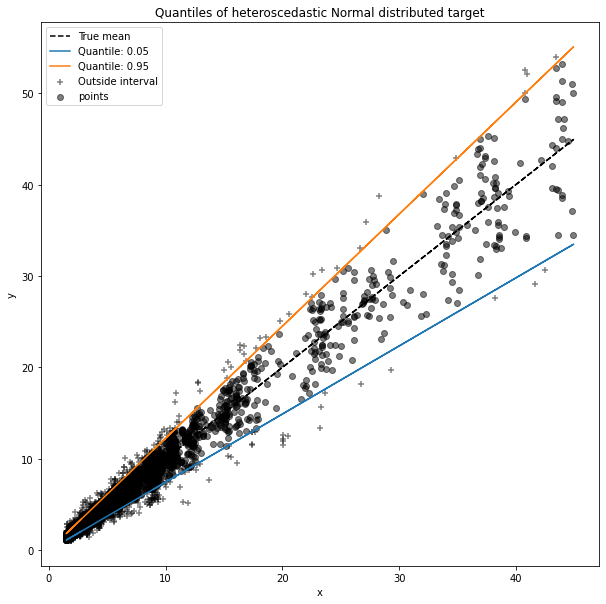

In [72]:
plt.figure(figsize=(10,10))

plt.plot(dataframes_dict_X_y['df_all_concat_lin_corr']['predictions_all_data'], dataframes_dict_X_y['df_all_concat_lin_corr']['predictions_all_data'], color="black", linestyle="dashed", label="True mean")

for quantile, y_pred in predictions_qr.items():
    plt.plot(dataframes_dict_X_y['df_all_concat_lin_corr']['predictions_all_data'], y_pred, label=f"Quantile: {quantile}")

plt.scatter(
    dataframes_dict_X_y['df_all_concat_lin_corr']['predictions_all_data'][out_bounds_predictions],
    dataframes_dict_X_y['df_all_concat_lin_corr']['y'][out_bounds_predictions],
    color="black",
    marker="+",
    alpha=0.5,
    label="Outside interval",
)

plt.scatter(
    dataframes_dict_X_y['df_all_concat_lin_corr']['predictions_all_data'][~out_bounds_predictions],
    dataframes_dict_X_y['df_all_concat_lin_corr']['y'][~out_bounds_predictions],
    color="black",
    alpha=0.5,
    label="points",
)
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
_ = plt.title("Quantiles of heteroscedastic Normal distributed target")

In [73]:
dataframes_dict_X_y['df_all_concat_lin_corr'].keys()

dict_keys(['X', 'y', 'X_train', 'X_test', 'y_train', 'y_test', 'predictions', 'residuals', 'predictions_all_data', 'model_qr_05_fit', 'model_qr_95_fit'])

In [74]:
dataframes_dict_X_y['df_all_concat_lin_corr']['model_qr_05_fit'].predict(np.array([[50]]))

array([37.24305384])

In [75]:
dataframes_dict_X_y['df_all_concat_lin_corr']['model_qr_95_fit'].predict(np.array([[50]]))

array([61.27455654])

In [76]:
out_bounds_predictions.sum()


651

In [77]:
dataframes_dict_X_y['df_all_concat_lin_corr']['y'].count() / (dataframes_dict_X_y['df_all_concat_lin_corr']['y'].count() + out_bounds_predictions.sum())

0.8944210184884852

# EXPORTING THE MODEL

In [78]:
# rf_model = rf_grid.best_estimator_
rf_model.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X'], dataframes_dict_X_y['df_all_concat_lin_corr']['y'])
joblib.dump(rf_model, utils.DIR_MODELS/"solar_rf_model_regressor.pkl")
joblib.dump(dataframes_dict_X_y['df_all_concat_lin_corr']['model_qr_05_fit'], utils.DIR_MODELS/"solar_qr_model_05.pkl")
joblib.dump(dataframes_dict_X_y['df_all_concat_lin_corr']['model_qr_95_fit'], utils.DIR_MODELS/"solar_qr_model_95.pkl")


['/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/models/solar_qr_model_95.pkl']

In [79]:
dataframes_dict_X_y['df_all_concat_lin_corr']['X_train']['capacity_mw'].describe()

count    4412.000000
mean        3.719991
std         3.428983
min         1.000000
25%         1.500000
50%         2.600000
75%         5.000000
max        23.100000
Name: capacity_mw, dtype: float64

In [4]:
solar_min_capacity = int(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train']['capacity_mw'].describe()['min'])
solar_max_capacity = int(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train']['capacity_mw'].describe()['max'])
data_aux = {'min_capacity': [solar_min_capacity],
            'max_capacity': [solar_max_capacity]
            }

In [5]:
solar_minmax_capacity = pd.DataFrame(data_aux)

In [7]:
solar_minmax_capacity.to_csv(utils.DIR_DATA_PROCESSED/"solar_minmax_capacity.csv")

Next: `notebooks/5-regressions-generation-wind.py` to build the model for regressions of Wind Power Plants